In [1]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import sys
from datetime import datetime
import matplotlib.ticker as ticker
import scipy as sc
import scipy.stats as stats
from scipy.optimize import curve_fit

##  Разработка фильтрации

In [13]:
#указываем местоположение данных
input_directory=r'C:\TOWER_DATA\TEST'
file_name1='191101000000 - Copy.dat'
file_name2='191101010000.dat'

In [34]:
#создаем df с правильным таймлайном за обрабатываемый период c шагом 1 сек
sec_in_file = 3600 

a = pd.to_datetime(file_name1[:12], errors='raise',format='%y%m%d%H%M%S').timestamp()
b = pd.to_datetime(file_name2[:12], errors='raise',format='%y%m%d%H%M%S').timestamp()+sec_in_file
time_line = pd.to_datetime(np.arange(a,b), unit='s')
time_line = pd.DataFrame(time_line)
time_line

0
0    2019-11-01 00:00:00
1    2019-11-01 00:00:01
2    2019-11-01 00:00:02
3    2019-11-01 00:00:03
4    2019-11-01 00:00:04
...                  ...
7195 2019-11-01 01:59:55
7196 2019-11-01 01:59:56
7197 2019-11-01 01:59:57
7198 2019-11-01 01:59:58
7199 2019-11-01 01:59:59

[7200 rows x 1 columns]

In [31]:
#создаем массив из двух подряд идущих файлов и переписываем временные индексы в удобный формат
data1 = pd.read_csv(input_directory+'/'+file_name1, sep='\s+', usecols=[0,3,5,7,9], names=['time','u','v','w','t'], comment='#', header=None)
data2 = pd.read_csv(input_directory+'/'+file_name2, sep='\s+', usecols=[0,3,5,7,9], names=['time','u','v','w','t'], comment='#', header=None)
data = pd.concat([data1, data2],ignore_index=True)
data = data.replace('y=',np.nan)
data = data.replace('T=',np.nan)
data['time'] = pd.to_datetime(data['time'], errors='raise',format='%y%m%d%H%M%S')
data['time'] = list(map(lambda x: x.timestamp(), data['time']))
data = data.sort_values('time', kind='mergesort')
data

time      u      v     w     t
0       1.572566e+09  -3.12  -2.35 -0.91 -1.75
1       1.572566e+09  -2.95  -2.37 -1.00 -1.82
2       1.572566e+09  -2.87  -2.30 -0.95 -1.84
3       1.572566e+09  -2.93  -2.24 -0.80 -1.83
4       1.572566e+09  -2.91  -2.17 -0.89 -1.80
...              ...    ...    ...   ...   ...
143599  1.572574e+09  -1.31  -0.04 -0.14 -1.33
143600  1.572574e+09  -1.49    0.1  0.00 -1.31
143601  1.572574e+09  -1.68  -0.06 -0.09 -1.32
143602  1.572574e+09  -1.66   0.04  0.03 -1.31
143603  1.572574e+09  -1.87   0.01  0.07 -1.33

[143604 rows x 5 columns]

In [32]:
#определяем количество подряд идущих одинаковых значений, выводятся все случаи, когда значений не 20, получаем список превышений и пропусков меньше секунды
p1,p2,p3=np.unique(data['time'],return_index=True,return_counts=True)
for i in range(len(p3)):
    if p3[i]!=20: print(i,p1[i],p2[i],p3[i])

0 1572566400.0 0 19
572 1572566992.0 11439 21
573 1572566993.0 11460 19
581 1572567001.0 11619 21
582 1572567002.0 11640 19
591 1572567011.0 11819 21
592 1572567012.0 11840 19
601 1572567021.0 12019 21
602 1572567022.0 12040 19
611 1572567031.0 12219 21
612 1572567032.0 12240 19
620 1572567040.0 12399 21
622 1572567042.0 12440 19
630 1572567050.0 12599 21
632 1572567052.0 12640 19
640 1572567060.0 12799 21
642 1572567062.0 12840 19
650 1572567070.0 12999 21
652 1572567072.0 13040 19
659 1572567079.0 13179 21
661 1572567081.0 13220 19
669 1572567089.0 13379 21
672 1572567092.0 13440 19
679 1572567099.0 13579 21
682 1572567102.0 13640 19
689 1572567109.0 13779 21
691 1572567111.0 13820 19
698 1572567118.0 13959 21
701 1572567121.0 14020 19
708 1572567128.0 14159 21
711 1572567131.0 14220 19
718 1572567138.0 14359 21
721 1572567141.0 14420 19
728 1572567148.0 14559 21
731 1572567151.0 14620 19
737 1572567157.0 14739 21
741 1572567161.0 14820 19
747 1572567167.0 14939 21
751 1572567171.0 1

In [38]:
data_sec = pd.DataFrame(np.array(np.unique(data['time'], return_counts=True, return_index=True)).T, columns=['sec', 'sec_ind', 'sec_len'])
inc_sec = data_sec.loc[data_sec['sec_len']!=20]
inc_sec

sec   sec_ind  sec_len
0     1.572566e+09       0.0     19.0
572   1.572567e+09   11439.0     21.0
573   1.572567e+09   11460.0     19.0
581   1.572567e+09   11619.0     21.0
582   1.572567e+09   11640.0     19.0
...            ...       ...      ...
7160  1.572574e+09  143203.0     21.0
7165  1.572574e+09  143304.0     19.0
7170  1.572574e+09  143403.0     21.0
7175  1.572574e+09  143504.0     19.0
7180  1.572574e+09  143603.0      1.0

[414 rows x 3 columns]

In [39]:
data_sec['sec_len'][0]

19.0

In [ ]:
#устранение подряд идущих превышений и пропусков
for i in inc_sec.index:
    if data_sec['sec_len'][i]>20 and data_sec['sec_len'][i-1]<20:
        for j in range (min(20-p3[i-1],p3[i]-20)):
            data[0][p2[i]+j]=data[0][p2[i-1]] 

In [10]:
#устранение подряд идущих превышений и пропусков
for i in range(1,len(p3)):
    if p3[i]>20 and p3[i-1]<20:
        for j in range (min(20-p3[i-1],p3[i]-20)):
            data[0][p2[i]+j]=data[0][p2[i-1]] 

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [11]:
#обновляем список превышений и пропусков меньше секунды
p1,p2,p3=np.unique(data[0],return_index=True,return_counts=True)
for i in range(len(p3)):
    if p3[i]!=20: print(i,p1[i],p2[i],p3[i])

0 2019-11-01T00:00:00.000000000 0 19
572 2019-11-01T00:09:52.000000000 11439 21
573 2019-11-01T00:09:53.000000000 11460 19
581 2019-11-01T00:10:01.000000000 11619 21
582 2019-11-01T00:10:02.000000000 11640 19
591 2019-11-01T00:10:11.000000000 11819 21
592 2019-11-01T00:10:12.000000000 11840 19
601 2019-11-01T00:10:21.000000000 12019 21
602 2019-11-01T00:10:22.000000000 12040 19
611 2019-11-01T00:10:31.000000000 12219 21
612 2019-11-01T00:10:32.000000000 12240 19
620 2019-11-01T00:10:40.000000000 12399 21
622 2019-11-01T00:10:42.000000000 12440 19
630 2019-11-01T00:10:50.000000000 12599 21
632 2019-11-01T00:10:52.000000000 12640 19
640 2019-11-01T00:11:00.000000000 12799 21
642 2019-11-01T00:11:02.000000000 12840 19
650 2019-11-01T00:11:10.000000000 12999 21
652 2019-11-01T00:11:12.000000000 13040 19
659 2019-11-01T00:11:19.000000000 13179 21
661 2019-11-01T00:11:21.000000000 13220 19
669 2019-11-01T00:11:29.000000000 13379 21
672 2019-11-01T00:11:32.000000000 13440 19
679 2019-11-01T00

3998 2019-11-01T01:06:58.000000000 79961 21
4003 2019-11-01T01:07:03.000000000 80062 19
4007 2019-11-01T01:07:07.000000000 80141 21
4013 2019-11-01T01:07:13.000000000 80262 19
4017 2019-11-01T01:07:17.000000000 80341 21
4023 2019-11-01T01:07:23.000000000 80462 19
4027 2019-11-01T01:07:27.000000000 80541 21
4033 2019-11-01T01:07:33.000000000 80662 19
4037 2019-11-01T01:07:37.000000000 80741 21
4043 2019-11-01T01:07:43.000000000 80862 19
4046 2019-11-01T01:07:46.000000000 80921 21
4052 2019-11-01T01:07:52.000000000 81042 19
4056 2019-11-01T01:07:56.000000000 81121 21
4062 2019-11-01T01:08:02.000000000 81242 19
4066 2019-11-01T01:08:06.000000000 81321 21
4072 2019-11-01T01:08:12.000000000 81442 19
4076 2019-11-01T01:08:16.000000000 81521 21
4083 2019-11-01T01:08:23.000000000 81662 19
4085 2019-11-01T01:08:25.000000000 81701 21
4092 2019-11-01T01:08:32.000000000 81842 19
4095 2019-11-01T01:08:35.000000000 81901 21
4102 2019-11-01T01:08:42.000000000 82042 19
4105 2019-11-01T01:08:45.0000000

In [12]:
#устранение подряд идущих пропусков и превышений 
for i in range(1,len(p3)):
    if p3[i]>20 and p3[i+1]<20:
       for j in range (min(20-p3[i+1],p3[i]-20)):
           data[0][p2[i+1]-1-j]=data[0][p2[i+1]] 

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [13]:
#обновляем список превышений и пропусков меньше секунды
p1,p2,p3=np.unique(data[0],return_index=True,return_counts=True)
for i in range(len(p3)):
    if p3[i]!=20: print(i,p1[i],p2[i],p3[i])

0 2019-11-01T00:00:00.000000000 0 19
620 2019-11-01T00:10:40.000000000 12399 21
622 2019-11-01T00:10:42.000000000 12440 19
630 2019-11-01T00:10:50.000000000 12599 21
632 2019-11-01T00:10:52.000000000 12640 19
640 2019-11-01T00:11:00.000000000 12799 21
642 2019-11-01T00:11:02.000000000 12840 19
650 2019-11-01T00:11:10.000000000 12999 21
652 2019-11-01T00:11:12.000000000 13040 19
659 2019-11-01T00:11:19.000000000 13179 21
661 2019-11-01T00:11:21.000000000 13220 19
669 2019-11-01T00:11:29.000000000 13379 21
672 2019-11-01T00:11:32.000000000 13440 19
679 2019-11-01T00:11:39.000000000 13579 21
682 2019-11-01T00:11:42.000000000 13640 19
689 2019-11-01T00:11:49.000000000 13779 21
691 2019-11-01T00:11:51.000000000 13820 19
698 2019-11-01T00:11:58.000000000 13959 21
701 2019-11-01T00:12:01.000000000 14020 19
708 2019-11-01T00:12:08.000000000 14159 21
711 2019-11-01T00:12:11.000000000 14220 19
718 2019-11-01T00:12:18.000000000 14359 21
721 2019-11-01T00:12:21.000000000 14420 19
728 2019-11-01T00

5628 2019-11-01T01:34:08.000000000 112562 21
5633 2019-11-01T01:34:13.000000000 112663 19
5637 2019-11-01T01:34:17.000000000 112742 21
5644 2019-11-01T01:34:24.000000000 112883 19
5647 2019-11-01T01:34:27.000000000 112942 21
5653 2019-11-01T01:34:33.000000000 113063 19
5657 2019-11-01T01:34:37.000000000 113142 21
5663 2019-11-01T01:34:43.000000000 113263 19
5667 2019-11-01T01:34:47.000000000 113342 21
5673 2019-11-01T01:34:53.000000000 113463 19
5676 2019-11-01T01:34:56.000000000 113522 21
5683 2019-11-01T01:35:03.000000000 113663 19
5686 2019-11-01T01:35:06.000000000 113722 21
5693 2019-11-01T01:35:13.000000000 113863 19
5696 2019-11-01T01:35:16.000000000 113922 21
5703 2019-11-01T01:35:23.000000000 114063 19
5706 2019-11-01T01:35:26.000000000 114122 21
5713 2019-11-01T01:35:33.000000000 114263 19
5715 2019-11-01T01:35:35.000000000 114302 21
5723 2019-11-01T01:35:43.000000000 114463 19
5725 2019-11-01T01:35:45.000000000 114502 21
5733 2019-11-01T01:35:53.000000000 114663 19
5735 2019-

In [14]:
#устранение превышений больше секунды и пропуска перед ними меньше длины превышения
for i in range(len(p3)):
    if p3[i]>40 and p3[i] <= int(p1[i]-p1[i-1])/1000000000*20:
        for j in range(p3[i]-20): #время в ns, а нужно в sec! Смотрим что меньше превышение или пропуск куда это превышение можно уместить
            new_date=data[0][p2[i]]-pd.to_timedelta(1+j//20,unit='S')
            data[0][p2[i+1]-20-j]=new_date

In [15]:
#обновляем список превышений и пропусков меньше секунды
p1,p2,p3=np.unique(data[0],return_index=True,return_counts=True)
for i in range(len(p3)):
    if p3[i]!=20: print(i,p1[i],p2[i],p3[i])

0 2019-11-01T00:00:00.000000000 0 19
620 2019-11-01T00:10:40.000000000 12399 21
622 2019-11-01T00:10:42.000000000 12440 19
630 2019-11-01T00:10:50.000000000 12599 21
632 2019-11-01T00:10:52.000000000 12640 19
640 2019-11-01T00:11:00.000000000 12799 21
642 2019-11-01T00:11:02.000000000 12840 19
650 2019-11-01T00:11:10.000000000 12999 21
652 2019-11-01T00:11:12.000000000 13040 19
659 2019-11-01T00:11:19.000000000 13179 21
661 2019-11-01T00:11:21.000000000 13220 19
669 2019-11-01T00:11:29.000000000 13379 21
672 2019-11-01T00:11:32.000000000 13440 19
679 2019-11-01T00:11:39.000000000 13579 21
682 2019-11-01T00:11:42.000000000 13640 19
689 2019-11-01T00:11:49.000000000 13779 21
691 2019-11-01T00:11:51.000000000 13820 19
698 2019-11-01T00:11:58.000000000 13959 21
701 2019-11-01T00:12:01.000000000 14020 19
708 2019-11-01T00:12:08.000000000 14159 21
711 2019-11-01T00:12:11.000000000 14220 19
718 2019-11-01T00:12:18.000000000 14359 21
721 2019-11-01T00:12:21.000000000 14420 19
728 2019-11-01T00

5464 2019-11-01T01:31:24.000000000 109283 19
5471 2019-11-01T01:31:31.000000000 109422 21
5474 2019-11-01T01:31:34.000000000 109483 19
5481 2019-11-01T01:31:41.000000000 109622 21
5484 2019-11-01T01:31:44.000000000 109683 19
5491 2019-11-01T01:31:51.000000000 109822 21
5494 2019-11-01T01:31:54.000000000 109883 19
5501 2019-11-01T01:32:01.000000000 110022 21
5504 2019-11-01T01:32:04.000000000 110083 19
5510 2019-11-01T01:32:10.000000000 110202 21
5514 2019-11-01T01:32:14.000000000 110283 19
5520 2019-11-01T01:32:20.000000000 110402 21
5524 2019-11-01T01:32:24.000000000 110483 19
5530 2019-11-01T01:32:30.000000000 110602 21
5534 2019-11-01T01:32:34.000000000 110683 19
5540 2019-11-01T01:32:40.000000000 110802 21
5544 2019-11-01T01:32:44.000000000 110883 19
5549 2019-11-01T01:32:49.000000000 110982 21
5554 2019-11-01T01:32:54.000000000 111083 19
5559 2019-11-01T01:32:59.000000000 111182 21
5564 2019-11-01T01:33:04.000000000 111283 19
5569 2019-11-01T01:33:09.000000000 111382 21
5574 2019-

In [16]:
#удаляем превышения, которые не удалось ликвидировать, и считаем количество удаленных данных
for i in range(len(p3)):
    if p3[i]>20:
        data.drop(np.arange(p2[i]+20,p2[i]+p3[i]),inplace=True)
        print(i,p1[i],p2[i],p3[i])

620 2019-11-01T00:10:40.000000000 12399 21
630 2019-11-01T00:10:50.000000000 12599 21
640 2019-11-01T00:11:00.000000000 12799 21
650 2019-11-01T00:11:10.000000000 12999 21
659 2019-11-01T00:11:19.000000000 13179 21
669 2019-11-01T00:11:29.000000000 13379 21
679 2019-11-01T00:11:39.000000000 13579 21
689 2019-11-01T00:11:49.000000000 13779 21
698 2019-11-01T00:11:58.000000000 13959 21
708 2019-11-01T00:12:08.000000000 14159 21
718 2019-11-01T00:12:18.000000000 14359 21
728 2019-11-01T00:12:28.000000000 14559 21
737 2019-11-01T00:12:37.000000000 14739 21
747 2019-11-01T00:12:47.000000000 14939 21
757 2019-11-01T00:12:57.000000000 15139 21
767 2019-11-01T00:13:07.000000000 15339 21
777 2019-11-01T00:13:17.000000000 15539 21
786 2019-11-01T00:13:26.000000000 15719 21
796 2019-11-01T00:13:36.000000000 15919 21
806 2019-11-01T00:13:46.000000000 16119 21
816 2019-11-01T00:13:56.000000000 16319 21
825 2019-11-01T00:14:05.000000000 16499 21
835 2019-11-01T00:14:15.000000000 16699 21
845 2019-11

In [17]:
#обновляем список превышений и пропусков меньше секунды
p1,p2,p3=np.unique(data[0],return_index=True,return_counts=True)
for i in range(len(p3)):
    if p3[i]!=20: print(i,p1[i],p2[i],p3[i])

0 2019-11-01T00:00:00.000000000 0 19
622 2019-11-01T00:10:42.000000000 12439 19
632 2019-11-01T00:10:52.000000000 12638 19
642 2019-11-01T00:11:02.000000000 12837 19
652 2019-11-01T00:11:12.000000000 13036 19
661 2019-11-01T00:11:21.000000000 13215 19
672 2019-11-01T00:11:32.000000000 13434 19
682 2019-11-01T00:11:42.000000000 13633 19
691 2019-11-01T00:11:51.000000000 13812 19
701 2019-11-01T00:12:01.000000000 14011 19
711 2019-11-01T00:12:11.000000000 14210 19
721 2019-11-01T00:12:21.000000000 14409 19
731 2019-11-01T00:12:31.000000000 14608 19
741 2019-11-01T00:12:41.000000000 14807 19
751 2019-11-01T00:12:51.000000000 15006 19
761 2019-11-01T00:13:01.000000000 15205 19
771 2019-11-01T00:13:11.000000000 15404 19
781 2019-11-01T00:13:21.000000000 15603 19
791 2019-11-01T00:13:31.000000000 15802 19
801 2019-11-01T00:13:41.000000000 16001 19
811 2019-11-01T00:13:51.000000000 16200 19
821 2019-11-01T00:14:01.000000000 16399 19
831 2019-11-01T00:14:11.000000000 16598 19
841 2019-11-01T00

In [18]:
#создаем список индексов недостающих значений
all_time_gap=[]
for i in range(len(try_date[0])):
    summ=np.sum(data[0] == try_date[0][i])
    if summ<20:
        for j in range(20-summ):
            print(try_date[0][i])
            all_time_gap.append(try_date[0][i])

2019-11-01 00:00:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:00
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:01
2019-11-01 00:01:02
2019-11-01 00:01:02
2019-11-01 00:01:02
2019-11-01 00:01:02
2019-11-01 00:01:02
2019-11-01 00:01:02
2019-11-01 00:01:02
2019-11-01 00:01:02
2019-11-01 00:01:02


2019-11-01 00:12:11
2019-11-01 00:12:21
2019-11-01 00:12:31
2019-11-01 00:12:41
2019-11-01 00:12:51
2019-11-01 00:13:01
2019-11-01 00:13:11
2019-11-01 00:13:21
2019-11-01 00:13:31
2019-11-01 00:13:41
2019-11-01 00:13:51
2019-11-01 00:14:01
2019-11-01 00:14:11
2019-11-01 00:14:21
2019-11-01 00:14:31
2019-11-01 00:14:41
2019-11-01 00:14:51
2019-11-01 00:15:01
2019-11-01 00:15:11
2019-11-01 00:15:21
2019-11-01 00:15:30
2019-11-01 00:15:41
2019-11-01 00:15:50
2019-11-01 00:16:00
2019-11-01 00:16:10
2019-11-01 00:16:20
2019-11-01 00:16:30
2019-11-01 00:37:13
2019-11-01 00:37:23
2019-11-01 00:37:33
2019-11-01 00:37:52
2019-11-01 00:38:02
2019-11-01 00:38:12
2019-11-01 00:38:22
2019-11-01 00:38:32
2019-11-01 00:38:42
2019-11-01 00:38:52
2019-11-01 00:39:02
2019-11-01 00:39:12
2019-11-01 00:39:22
2019-11-01 00:39:32
2019-11-01 00:39:42
2019-11-01 00:39:53
2019-11-01 00:40:02
2019-11-01 00:40:12
2019-11-01 00:40:22
2019-11-01 00:40:32
2019-11-01 00:40:42
2019-11-01 00:40:52
2019-11-01 00:41:02


In [19]:
#добавляем недостающие значения
df=pd.DataFrame(all_time_gap)
data=pd.concat([data,df],ignore_index=True)
data=data.sort_values(0, kind='mergesort')
data=data.reset_index(drop=True)

In [46]:
data[:][:72000].to_csv(r'C:\TOWER_DATA\TEST\191101000000 - New.dat', date_format='%YYYY%MM%DD %hh%mm%ss', na_rep='Nan', sep=' ', header = ['date','U','V','Z','T'], index=False)

## массив готов к заполнению пропусков!

In [68]:
try_data=pd.read_csv(r'C:\TOWER_DATA\TEST\200501120000.dat', sep='\s+', usecols=[0,3,5,7,9], names=['date','u','v','w','T'], header=None)

In [69]:
try_data

date     u     v     w     T
0      200501120000  0.86 -0.13  0.41  9.58
1      200501120000  0.80 -0.11  0.42  9.62
2      200501120000  0.88 -0.16  0.40  9.60
3      200501120000  0.86 -0.18  0.41  9.56
4      200501120000  0.91 -0.26  0.42  9.53
...             ...   ...   ...   ...   ...
71997  200501125959  2.43 -0.22  0.36  9.89
71998  200501125959  2.58 -0.08  0.41  9.88
71999  200501125959  2.57 -0.28  0.40  9.81
72000  200501125959  2.50 -0.15  0.38  9.84
72001  200501130000  2.52 -0.14  0.39  9.78

[72002 rows x 5 columns]

In [70]:
len_gap=1200
start_gap=5000
end_gap=start_gap+len_gap
T = try_data['T'][start_gap-len_gap:end_gap+len_gap].values
W = try_data['w'][start_gap-len_gap:end_gap+len_gap].values

In [ ]:
T_new = T_ma_cov
W_new = W_ma_cov
print('T')
stat_out(T_new, std_T, T)
print('W')
stat_out(W_new, std_T, W)

WT = f_WT(W,T)
WT_gap = f_WT(W_gap, T_gap)
WT_new = f_WT(W_new, T_new)
print('WT')
print('Искомый поток тепла: ', WT)
print('Поток тепла с пропуском:', WT_gap)
print('Полученный поток тепла:', WT_new)
print('Разница искомого и потока тепла c пропуском:', WT-WT_gap, (WT-WT_gap)*100/WT, '%')
print('Разница искомого и полученного потока тепла:', WT-WT_new, (WT-WT_new)*100/WT, '%')

In [72]:
T_new = T_walk_cov
W_new = W_walk_cov
print('T')
stat_out(T_new, std_T, T)
print('W')
stat_out(W_new, std_T, W)

WT = f_WT(W,T)
WT_gap = f_WT(W_gap, T_gap)
WT_new = f_WT(W_new, T_new)
print('WT')
print('Искомый поток тепла: ', WT)
print('Поток тепла с пропуском:', WT_gap)
print('Полученный поток тепла:', WT_new)
print('Разница искомого и потока тепла c пропуском:', WT-WT_gap, (WT-WT_gap)*100/WT, '%')
print('Разница искомого и полученного потока тепла:', WT-WT_new, (WT-WT_new)*100/WT, '%')

NameError: name 'T_walk_cov' is not defined

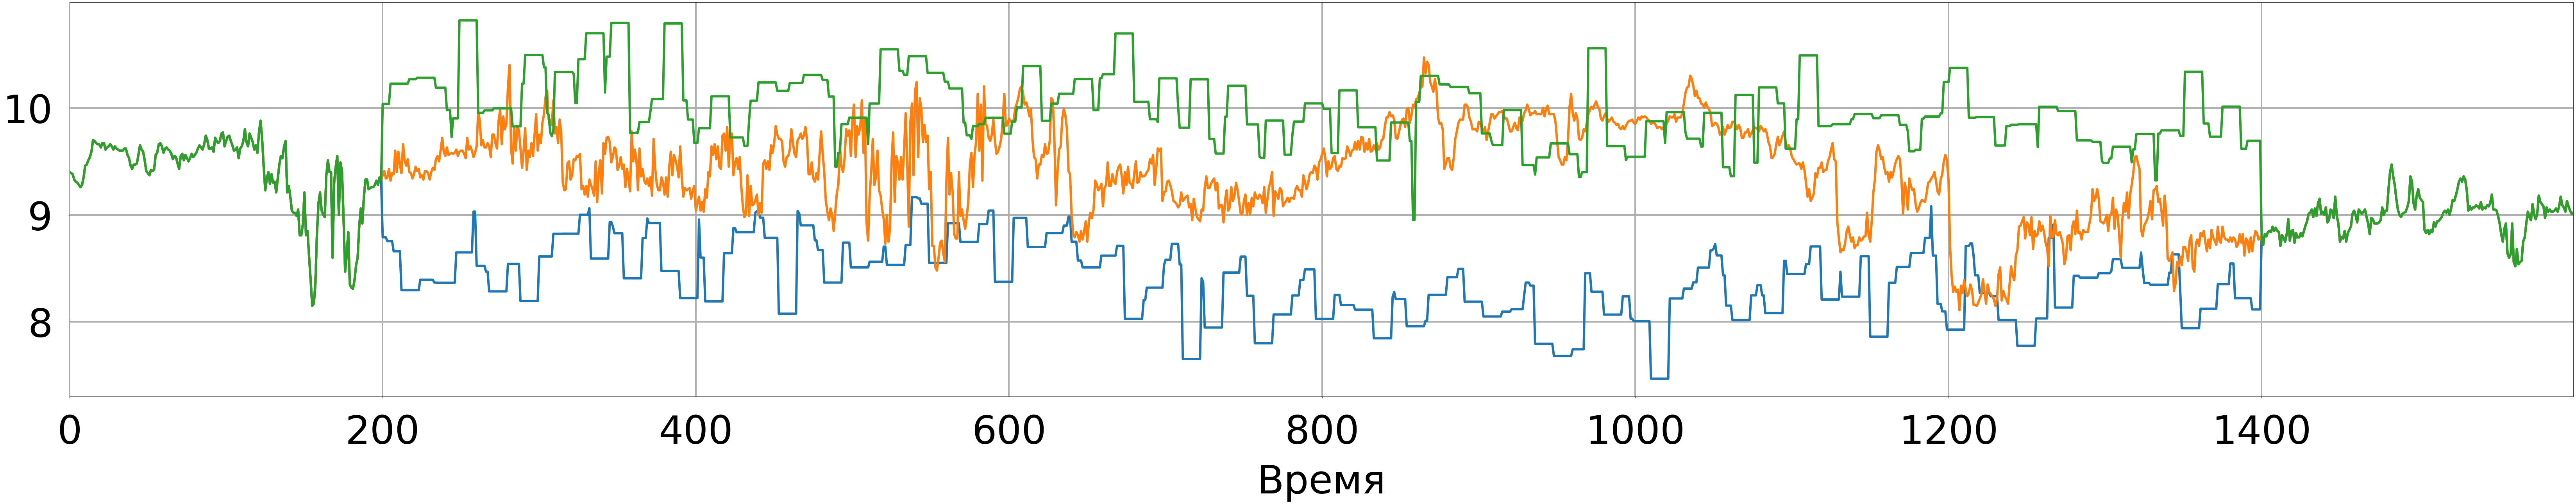

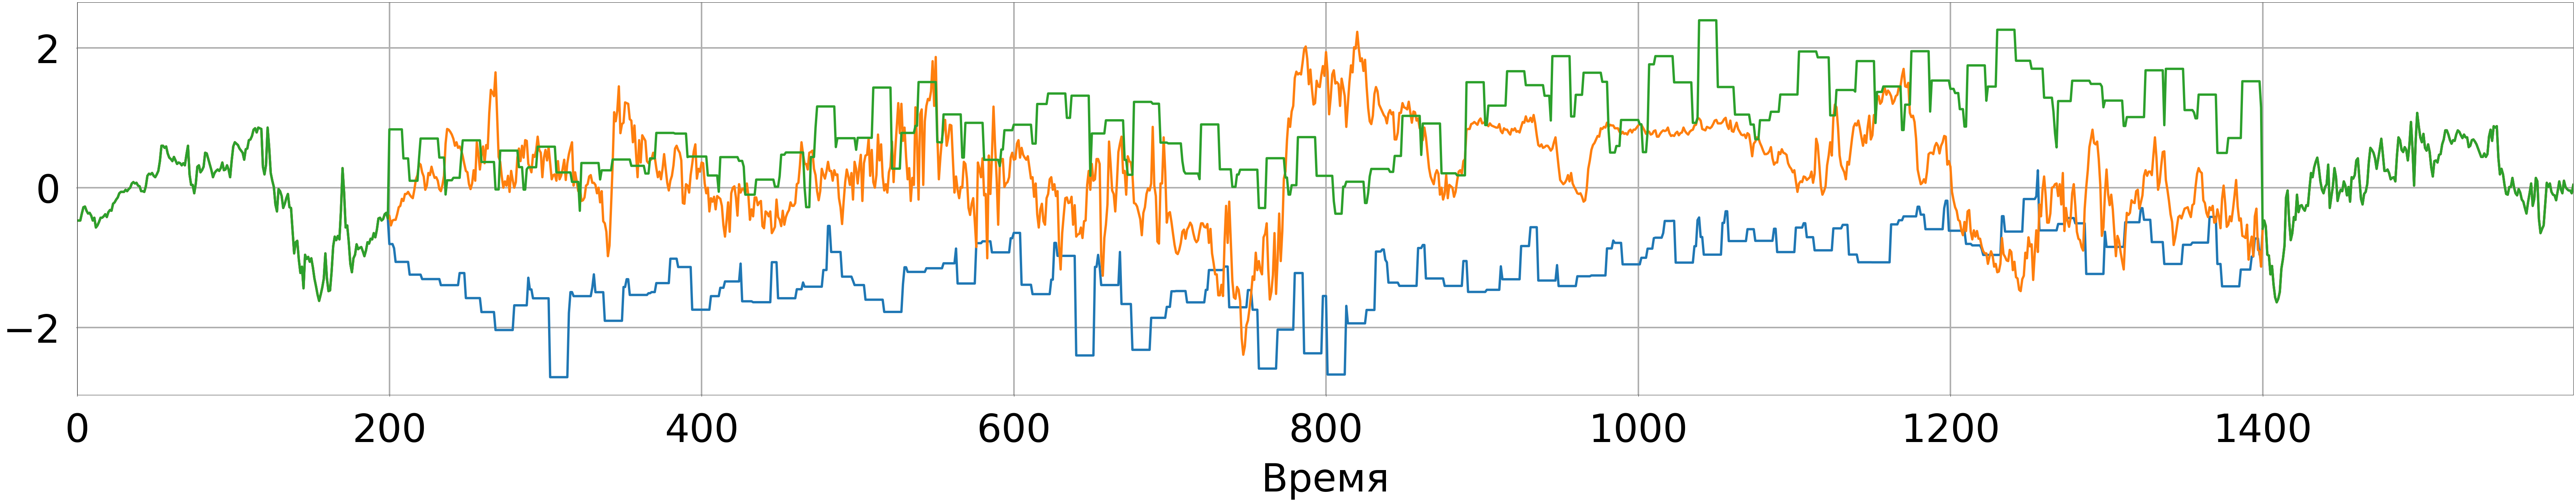

In [244]:
gap_plot(1000, 2600, T_min, T, T_max)
gap_plot(1000, 2600, W_min, W, W_max)

In [167]:
delta_T = T_gap[1:]-T_gap[:-1]
delta_W = W_gap[1:]-W_gap[:-1]

In [226]:
np.corrcoef(T[1200:2400],T[1199:2399]) #построить автокорреляционные диаграммы для исходных рядов T и W и восстановленных

array([[1.        , 0.93228196],
       [0.93228196, 1.        ]])

In [241]:
np.corrcoef(T_ma_gaus[1200:2400],T_ma_gaus[1199:2399]) #построить автокорреляционные диаграммы для исходных рядов T и W и восстановленных

array([[1.       , 0.2473183],
       [0.2473183, 1.       ]])

In [202]:
def stat_out(T_new, T_gap, T):
    print('*************************************************************************************************************')
    print('Полученое std: ', np.nanstd(T_new[len_gap:-len_gap]))
    print('Std полученного ряда: ', np.nanstd(T_new))
    print('')
    print('Среднее между std до и после пропуска за период эквивалентный пропущенному: ', np.mean([np.nanstd(T_gap[:len_gap]),np.nanstd(T_gap[-len_gap:])]))
    print('Std всего ряда с пропуском: ',np.nanstd(T_gap))
    print('')
    print('Искомое std: ',np.nanstd(T[len_gap:-len_gap]))
    print('Std искомого ряда: ',np.nanstd(T))
    print('')
    delta = np.nanstd(T[len_gap:-len_gap])-np.nanstd(T_gap[len_gap:-len_gap])
    print('Разница искомого и std c пропуском:', delta, delta*100/np.nanstd(T[len_gap:-len_gap]),'%')
    delta = np.nanstd(T)-np.nanstd(T_gap)
    print('Разница искомого и std ряда с пропуском:', delta, delta*100/np.nanstd(T[len_gap:-len_gap]),'%')
    print('')
    delta = np.nanstd(T[len_gap:-len_gap])-np.nanstd(T_new[len_gap:-len_gap])
    print('Разница искомого и полученного std:', delta, delta*100/np.nanstd(T[len_gap:-len_gap]),'%')
    delta = np.nanstd(T)-np.nanstd(T_new)
    print('Разница искомого и полученного std ряда:', delta, delta*100/np.nanstd(T[len_gap:-len_gap]),'%')
    print('===========================================================================================================')
    print('Полученное mean: ', np.nanmean(T_new[len_gap:-len_gap]))
    print('Mean полученного ряда: ', np.nanmean(T_new))
    print('')
    print('Среднее между mean до и после пропуска за период эквивалентный пропущенному: ', np.mean([np.nanmean(T_gap[:len_gap]),np.nanmean(T_gap[-len_gap:])]))
    print('Mean всего ряда с пропуском: ',np.nanmean(T_gap))
    print('')
    print('Искомое mean: ',np.nanmean(T[len_gap:-len_gap]))
    print('Mean искомого ряда: ',np.nanmean(T))
    print('')
    delta = np.nanmean(T[len_gap:-len_gap])-np.nanmean(T_gap[len_gap:-len_gap])
    print('Разница искомого и mean c пропуском:', delta, delta*100/np.nanmean(T[len_gap:-len_gap]),'%')
    delta = np.nanmean(T)-np.nanmean(T_gap)
    print('Разница искомого и mean ряда с пропуском:', delta, delta*100/np.nanmean(T[len_gap:-len_gap]),'%')
    print('')
    delta = np.nanmean(T[len_gap:-len_gap])-np.nanmean(T_new[len_gap:-len_gap])
    print('Разница искомого и полученного mean:', delta, delta*100/np.nanmean(T[len_gap:-len_gap]),'%')
    delta = np.nanmean(T)-np.nanmean(T_new)
    print('Разница искомого и полученного mean ряда:', delta, delta*100/np.nanmean(T[len_gap:-len_gap]),'%')
    print('*************************************************************************************************************\n')

In [88]:
def gap_plot(start, end, T_new1, T_new2, T):
    fig, ax1 = plt.subplots(figsize=(100, 20))

    plt.plot(T_new1[start:end], linewidth=6)
    plt.plot(T_new2[start:end], linewidth=6)
    plt.plot(T[start:end], linewidth=6)

    ax1.tick_params(axis='both', labelsize=100, pad=40.0)
    #ax1.set_title('01.11.2019 18.8 м', fontsize=100, loc='left')
    #ax1.set_ylabel('$Температура,$ $°С$', fontsize=100, labelpad=50)
    ax1.set_xlabel('Время', fontsize=100, labelpad=30)
    #ax1.legend(loc='upper left', fontsize=75)
    ax1.grid(linewidth=4)
    ax1.margins(x=0)
    plt.subplots_adjust(left=0.07, bottom=0.2, right=0.96, top=0.90)

### Тестирование алгоритмов заполнения пропусков

In [255]:
input_directory = r'C:/TOWER_DATA/TEST/May/'
files = os.listdir(input_directory) #спсок файлов в папке с данными

In [256]:
data = pd.read_csv(input_directory+files[0], sep='\s+', usecols=[0,3,5,7,9], names=['date','u','v','w','T'], header=None)    
for i in files[1:50]:
    data1 = pd.read_csv(input_directory+i, sep='\s+', usecols=[0,3,5,7,9], names=['date','u','v','w','T'], header=None)    
    data=pd.concat([data, data1],ignore_index=True)

In [259]:
data.head()

date     u     v     w     T
0  200501000000  2.29 -0.97 -0.98  6.96
1  200501000000  2.15 -1.17 -0.82  6.91
2  200501000000  2.15 -0.82 -0.89  6.87
3  200501000000  2.51 -0.56 -0.91  6.95
4  200501000000  2.35 -0.65 -1.25  6.89

In [257]:
data.shape

(3600107, 5)

In [260]:
data.loc[data['T'].isna()]

Empty DataFrame
Columns: [date, u, v, w, T]
Index: []

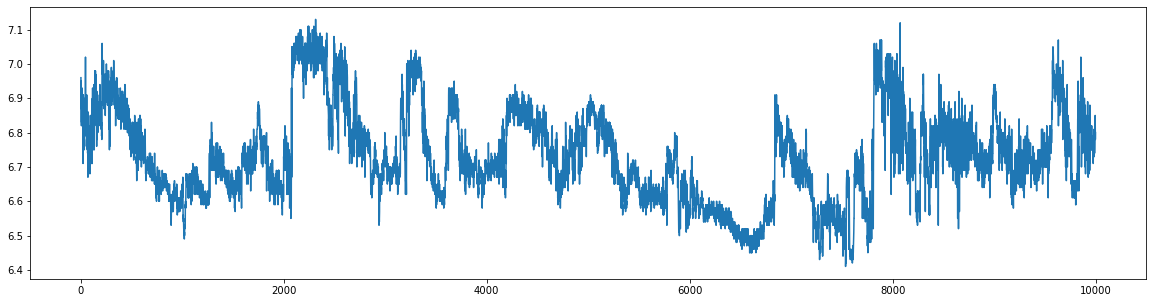

In [339]:
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(data['T'][0:10000])

In [263]:
lg=1200
index_s=np.arange(lg,len(data),lg*3)
index_e=np.arange(lg*2,len(data),lg*3)
len(index_s)

1000

In [262]:
data_gap=data.copy()
for i in range(len(index_s)):
    data_gap.loc[index_s[i]:index_e[i]-1,['T','w']]=np.nan

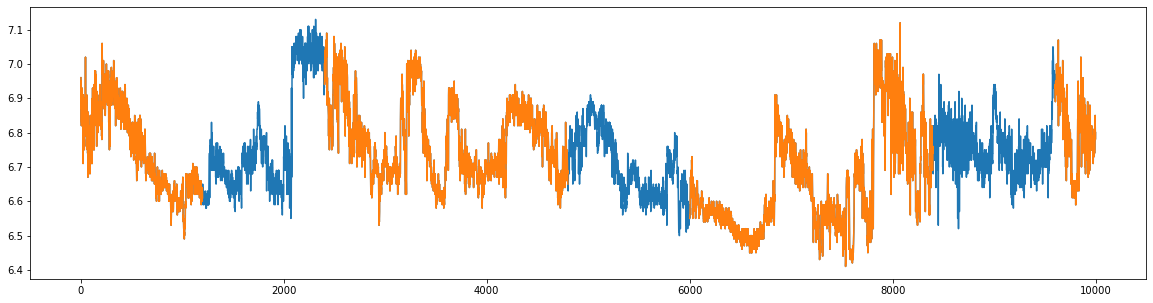

In [340]:
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(data['T'][:10000])
plt.plot(data_gap['T'][:10000])

In [230]:
#T_walk, W_walk = gapfilling('walk', data_gap, 'T', 'w', index_s[0], index_e[0])
T_walk_cov, W_walk_cov = gapfilling('walk_cov', data_gap, 'T', 'w', index_s[0], index_e[0])
#T_ma_cov, W_ma_cov = gapfilling('ma_cov', data_gap, 'T', 'w', index_s[0], index_e[0])

In [214]:
delta_T = data_gap['T'][0:3599].values - data_gap['T'][1:3600].values
std = np.zeros(1200)
std_delta = np.zeros(1200)
for i in range(1200):
    std[i]=np.nanstd(data_gap['T'][i:i+2400])
    std_delta[i]=np.nanstd(delta_T[i:i+2400])
    

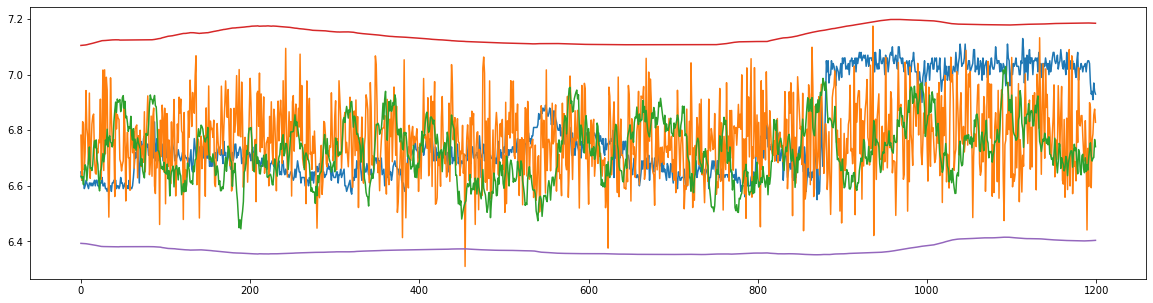

In [341]:
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(data['T'][1200:2400].values)
plt.plot(T_ma_cov)
#plt.plot(T_walk)
plt.plot(T_walk_cov)
plt.plot(T_ma+3*std)
plt.plot(T_ma-3*std)



#gap_plot(start, end, T_new1, T_new2, T)

In [354]:
pd.read_csv(r'C:/TOWER_DATA/TEST/gap_stat/T_24000.csv', sep=' ').mean()

mean     9.810096
std      0.285935
acor     0.895897
max     10.964133
min      9.021200
dtype: float64

In [353]:
pd.read_csv(r'C:/TOWER_DATA/TEST/gap_stat/T_gap_24000.csv', sep=' ').mean()

mean     9.809068
std      0.284206
acor     0.896108
max     10.899533
min      9.038200
dtype: float64

In [369]:
pd.read_csv(r'C:/TOWER_DATA/TEST/gap_stat/WT_24000.csv', sep=' ').mean()

WT    0.080788
dtype: float64

In [394]:
WT_24000 = pd.read_csv(r'C:/TOWER_DATA/TEST/gap_stat/WT_24000.csv', sep=' ')
WT_gap_24000 = pd.read_csv(r'C:/TOWER_DATA/TEST/gap_stat/WT_gap_24000.csv', sep=' ')
d_WT_gap = (WT_24000['WT']-WT_gap_24000['WT'])*100/WT_24000['WT']
d_WT_gap_mean = d_WT_gap.mean()

T_24000 = pd.read_csv(r'C:/TOWER_DATA/TEST/gap_stat/T_24000.csv', sep=' ')
T_gap_24000 = pd.read_csv(r'C:/TOWER_DATA/TEST/gap_stat/T_gap_24000.csv', sep=' ')



print('Разница WT и WT_gap:',d_WT_gap_mean)

Разница WT и WT_gap: -6.790229144745842


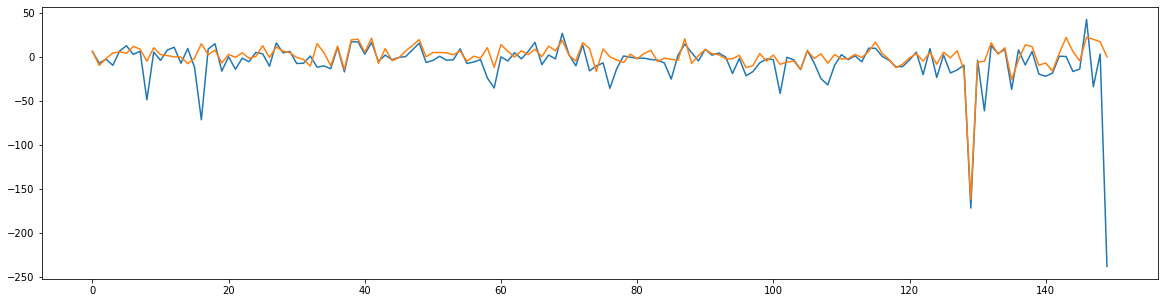

In [389]:
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(d_WT_gap)
plt.plot(d_WT_lin_cov)

In [367]:
mean_time = 20
mean_time = mean_time*20*60
file_T = open(output_directory+f'T_{mean_time}.csv','w')
file_W = open(output_directory+f'W_{mean_time}.csv','w')
file_WT = open(output_directory+f'WT_{mean_time}.csv','w')

print('mean', 'std', 'acor', 'max', 'min', file=file_T)
print('mean', 'std', 'acor', 'max', 'min', file=file_W)
print('WT', file=file_WT)
    
for i in range (mean_time, len(data_new), mean_time):
    T_new = data.loc[i-mean_time:i-1,'T'].values
    W_new = data.loc[i-mean_time:i-1,'w'].values
    gap_stat(T_new, file_T)
    gap_stat(W_new, file_W)
    f_WT(W_new, T_new, file_WT)
    
#for i in range(len(index_s)):
#    T_new = data.loc[index_s[i]:index_e[i]-1,'T'].values 
#    W_new = data.loc[index_s[i]:index_e[i]-1,'w'].values
#    gap_stat(T_new, file_T)
#    gap_stat(W_new, file_W)

file_T.close()
file_W.close()
file_WT.close()

In [ ]:
#describe

In [399]:
mean_time=20
mean_time = mean_time*20*60
output_directory=r'C:/TOWER_DATA/TEST/gap_stat/'
test_list=['walk_cov'] # 'lin','lin_gaus','lin_cov','ma','ma_gaus','ma_cov','walk',

for name in test_list:
    
    data_new=data_gap.copy()
    
    file_T = open(output_directory+f'T_{name}_{mean_time}.csv','w')
    file_W = open(output_directory+f'W_{name}_{mean_time}.csv','w') 
    file_WT = open(output_directory+f'WT_{name}_{mean_time}.csv','w')
    
    
    print('mean', 'std', 'acor', 'max', 'min', file=file_T)
    print('mean', 'std', 'acor', 'max', 'min', file=file_W)
    print('WT', file=file_WT)
    
    for i in range(len(index_s)):
        
        T_new, W_new = gapfilling(name, data_gap, 'T', 'w', index_s[i], index_e[i])
        
        #раскоментить, если нужна статистика по пропускам
        #gap_stat(T_new, file_T)
        #gap_stat(W_new, file_W)
        
        #раскоментить, если нужна статистика по периодам осреднения
        data_new.loc[index_s[i]:index_e[i]-1,'T'] = T_new 
        data_new.loc[index_s[i]:index_e[i]-1,'w'] = W_new
        
        if i%100==0: print('Заполнено пропусков:', i*100/len(index_s), '%')
    #раскоментить, если нужна статистика по периодам осреднения
    for i in range (mean_time, len(data_new), mean_time):
        T_new = data_new.loc[i-mean_time:i-1,'T'].values
        W_new = data_new.loc[i-mean_time:i-1,'w'].values
        gap_stat(T_new, file_T)
        gap_stat(W_new, file_W)
        f_WT(W_new, T_new, file_WT)
        
        if (i/mean_time)%10==0: print('Обработано периодов осреднения:', (i/mean_time)*100/len(index_s), '%')
        
    file_T.close()
    file_W.close()
    file_WT.close()
    
    

In [401]:
out_list = ['gap','lin','lin_gaus','lin_cov','ma','ma_gaus','ma_cov','walk', 'walk_cov'] #
mean=24000
WT = pd.read_csv(f'C:/TOWER_DATA/TEST/gap_stat/WT_{mean}.csv', sep=' ')
T = pd.read_csv(f'C:/TOWER_DATA/TEST/gap_stat/T_{mean}.csv', sep=' ')
W = pd.read_csv(f'C:/TOWER_DATA/TEST/gap_stat/W_{mean}.csv', sep=' ')

for name in out_list:
    WT_new = pd.read_csv(f'C:/TOWER_DATA/TEST/gap_stat/WT_{name}_{mean}.csv', sep=' ')
    d_WT = (WT['WT']-WT_new['WT'])*100/WT['WT']
    
    T_new = pd.read_csv(f'C:/TOWER_DATA/TEST/gap_stat/T_{name}_{mean}.csv', sep=' ')
    d_T_mean = (T['mean']-T_new['mean'])*100/T['mean']
    d_T_std = (T['std']-T_new['std'])*100/T['std']
    d_T_acor = (T['acor']-T_new['acor'])*100/T['acor']
    d_T_max = (T['max']-T_new['max'])*100/T['max']
    d_T_min = (T['min']-T_new['min'])*100/T['min']
    
    W_new = pd.read_csv(f'C:/TOWER_DATA/TEST/gap_stat/W_{name}_{mean}.csv', sep=' ')
    d_W_mean = (W['mean']-W_new['mean'])*100/W['mean']
    d_W_std = (W['std']-W_new['std'])*100/W['std']
    d_W_acor = (W['acor']-W_new['acor'])*100/W['acor']
    d_W_max = (W['max']-W_new['max'])*100/W['max']
    d_W_min = (W['min']-W_new['min'])*100/W['min']
    
    print(f'Период осреднения: {mean}')
    print(f'Длина пропуска: {lg}')
    print('============================================================================')
    print(f'Разница WT и WT_{name}:', d_WT.mean(), '%')
    print('============================================================================')
    print(f'Разница mean T и mean T_{name}:', d_T_mean.mean(), '%')
    print(f'Разница std T и std T_{name}:', d_T_std.mean(), '%')
    print(f'Разница acor T и acor T_{name}:', d_T_acor.mean(), '%')
    print(f'Разница max T и max T_{name}:', d_T_max.mean(), '%')
    print(f'Разница min T и min T_{name}:', d_T_min.mean(), '%')
    print('============================================================================')
    print(f'Разница mean W и mean W_{name}:', d_W_mean.mean(), '%')
    print(f'Разница std W и std W_{name}:', d_W_std.mean(), '%')
    print(f'Разница acor W и acor W_{name}:', d_W_acor.mean(), '%')
    print(f'Разница max W и max W_{name}:', d_W_max.mean(), '%')
    print(f'Разница min W и min W_{name}:', d_W_min.mean(), '%')
    print('')

Период осреднения: 24000
Длина пропуска: 1200
Разница WT и WT_gap: -6.790229144745842 %
Разница mean T и mean T_gap: 0.017275319948479095 %
Разница std T и std T_gap: 0.169272254906959 %
Разница acor T и acor T_gap: -0.062123795384418146 %
Разница max T и max T_gap: 0.5382959285909703 %
Разница min T и min T_gap: -0.2053596541103286 %
Разница mean W и mean W_gap: 51.01727335964766 %
Разница std W и std W_gap: 0.2897254744363474 %
Разница acor W и acor W_gap: 0.037859253562017844 %
Разница max W и max W_gap: 5.781118715601681 %
Разница min W и min W_gap: 4.415027894868552 %

Период осреднения: 24000
Длина пропуска: 1200
Разница WT и WT_lin: 29.28800681210616 %
Разница mean T и mean T_lin: 0.013802341996821269 %
Разница std T и std T_lin: 13.407227904449341 %
Разница acor T и acor T_lin: -1.3371197966074837 %
Разница max T и max T_lin: 0.5382959285909703 %
Разница min T и min T_lin: -0.2053596541103286 %
Разница mean W и mean W_lin: 45.92935433615125 %
Разница std W и std W_lin: 17.18168

In [324]:
def gap_stat(X, X_out):
    not_nan = np.logical_not(np.isnan(X))
    X=X[not_nan]        
    acor = np.corrcoef(X[1:],X[:-1])
    print(np.mean(X), np.std(X), acor[0,1], np.max(X), np.min(X), file=X_out)

In [403]:
def gapfilling(name, data_gap, var1, var2, start_gap, end_gap):
    
    lg = end_gap-start_gap
    T = data_gap[var1][start_gap-lg:end_gap+lg].values
    W = data_gap[var2][start_gap-lg:end_gap+lg].values
    
    #линейный тренд
    if name=='lin' or name=='lin_cov' or name=='lin_gaus':
        T_lin, W_lin = T.copy(), W.copy()
        T_lin[lg:-lg] = np.linspace(np.nanmean(T[:lg]),np.nanmean(T[-lg:]),lg)
        W_lin[lg:-lg] = np.linspace(np.nanmean(W[:lg]),np.nanmean(W[-lg:]),lg)
        T_new, W_new = T_lin[lg:2*lg], W_lin[lg:2*lg]
    
    #линейный тренд + нормальное распределение
    if name=='lin_gaus':
        T_lin_gaus, W_lin_gaus = T.copy(), W.copy()
        for i in range(lg,2*lg):
            dT, dW = T[i-lg:i+lg], W[i-lg:i+lg]
            not_nan = np.logical_not(np.isnan(dT))
            std_T = np.std(dT[not_nan])
            std_W = np.std(dW[not_nan])
            
            T_lin_gaus[i] = np.random.normal(T_lin[i], std_T)
            W_lin_gaus[i] = np.random.normal(W_lin[i], std_W)
        T_new, W_new = T_lin_gaus[lg:2*lg], W_lin_gaus[lg:2*lg]
    
    #линейный тренд + скоррелированное нормальное распределение
    if name=='lin_cov':
        T_lin_cov, W_lin_cov = T.copy(), W.copy()
        for i in range(lg,2*lg):
            dT, dW = T[i-lg:i+lg], W[i-lg:i+lg]
            not_nan = np.logical_not(np.isnan(dT))
            cov_TW = np.cov(dT[not_nan],dW[not_nan])
            T_lin_cov[i], W_lin_cov[i] = np.random.multivariate_normal((T_lin[i],W_lin[i]), cov_TW)
        T_new, W_new = T_lin_cov[lg:2*lg], W_lin_cov[lg:2*lg]
     
   #скользящее среднее 
    if name=='ma':
        T_ma, W_ma = T.copy(), W.copy()
        for i in range(lg,2*lg): 
            T_ma[i] = np.nanmean(T[i-lg:i+lg])
            W_ma[i] = np.nanmean(W[i-lg:i+lg])  
        T_new, W_new = T_ma[lg:2*lg], W_ma[lg:2*lg]

    #скользящее среднее + нормальное распределение
    if name=='ma_gaus':
        T_ma_gaus, W_ma_gaus = T.copy(), W.copy()
        for i in range(lg,2*lg):
            dT, dW = T[i-lg:i+lg], W[i-lg:i+lg]
            not_nan = np.logical_not(np.isnan(dT))
            T_ma = np.mean(dT[not_nan])
            W_ma = np.mean(dW[not_nan]) 
            std_T = np.std(dT[not_nan])
            std_W = np.std(dW[not_nan])
            
            T_ma_gaus[i] = np.random.normal(T_ma, std_T)
            W_ma_gaus[i] = np.random.normal(W_ma, std_W)
        T_new, W_new = T_ma_gaus[lg:2*lg], W_ma_gaus[lg:2*lg]
    
    #скользящее среднее + скоррелированное нормальное распределение
    if name=='ma_cov' or name=='walk_cov':
        T_ma_cov, W_ma_cov = T.copy(), W.copy()
        T_ma, W_ma = T.copy(), W.copy()
        for i in range(lg,2*lg):
            dT, dW = T[i-lg:i+lg], W[i-lg:i+lg]
            not_nan = np.logical_not(np.isnan(dT))
            T_ma[i] = np.mean(dT[not_nan])
            W_ma[i] = np.mean(dW[not_nan]) 
            cov_TW = np.cov(dT[not_nan],dW[not_nan])
            
            T_ma_cov[i], W_ma_cov[i] = np.random.multivariate_normal((T_ma[i],W_ma[i]), cov_TW)
        T_new, W_new = T_ma_cov[lg:2*lg], W_ma_cov[lg:2*lg]
    
    #приращения величин 
    if name=='walk' or name=='walk_cov': 
        delta_T, delta_W = T[:-1]-T[1:], W[:-1]-W[1:]
    
    #случайное блуждание в рамках трех сигм 
    if name == 'walk':
        T_walk, W_walk = T.copy(), W.copy()
        for i in range(lg,2*lg):
            std_delta_T = np.nanstd(delta_T[i-lg:i+lg])
            std_delta_W = np.nanstd(delta_W[i-lg:i+lg])
            std_T = np.nanstd(T[i-lg:i+lg])
            std_W = np.nanstd(W[i-lg:i+lg])
            T_ma = np.nanmean(T[i-lg:i+lg])
            W_ma = np.nanmean(W[i-lg:i+lg]) 

            dT = np.random.normal(0, std_delta_T)
            dW = np.random.normal(0, std_delta_W)
            T_walk[i] = T_walk[i-1]+dT
            W_walk[i] = W_walk[i-1]+dW
            if T_walk[i]>T_ma+3*std_T or T_walk[i]<T_ma-3*std_T: T_walk[i] = T_walk[i-1]-dT
            if W_walk[i]>W_ma+3*std_W or W_walk[i]<W_ma-3*std_W: W_walk[i] = W_walk[i-1]-dW
        T_new, W_new = T_walk[lg:2*lg], W_walk[lg:2*lg]
            
    #скоррелированное случайное блуждание в рамках скоррелированного нормального распределения
    if name == 'walk_cov':
        window = int(np.ceil(lg/200)) #окно шириной в 1% пропуска (не менее 1)
        
        T_walk_cov, W_walk_cov = T.copy(), W.copy()
        for i in range(lg,2*lg):
            
            dT, dW = delta_T[i-lg:i+lg], delta_W[i-lg:i+lg]
            not_nan = np.logical_not(np.isnan(dT))
            cov_delta_TW = np.cov(dT[not_nan],dW[not_nan])
            
            T_max, T_min = np.nanmax(T_ma_cov[i-window:i+window]), np.nanmin(T_ma_cov[i-window:i+window])
            W_max, W_min = np.nanmax(W_ma_cov[i-window:i+window]), np.nanmin(W_ma_cov[i-window:i+window])
            
            dT, dW = np.random.multivariate_normal((0,0), cov_delta_TW)
            
            T_walk_cov[i] = T_walk_cov[i-1]+dT
            W_walk_cov[i] = W_walk_cov[i-1]+dW
            if T_walk_cov[i]>T_max or T_walk_cov[i]<T_min: 
                if abs(T_walk_cov[i]-T_ma[i])>abs(T_walk_cov[i-1]-dT-T_ma[i]): T_walk_cov[i] = T_walk_cov[i-1]-dT
            if W_walk_cov[i]>W_max or W_walk_cov[i]<W_min: 
                if abs(W_walk_cov[i]-W_ma[i])>abs(W_walk_cov[i-1]-dW-W_ma[i]): W_walk_cov[i] = W_walk_cov[i-1]-dW
        T_new, W_new = T_walk_cov[lg:2*lg], W_walk_cov[lg:2*lg]
    
    return T_new, W_new


In [344]:
def ax_c(x,a,c):
    return a*x+c

def f_WT(W, T, file_WT):
    not_nan = np.logical_not(np.isnan(T))
    x = np.arange(len(T[not_nan]))

    coef_W, _ = curve_fit(ax_c, x, W[not_nan])
    coef_T, _ = curve_fit(ax_c, x, T[not_nan])

    lin_W = ax_c(np.arange(len(W)),*coef_W)
    lin_T = ax_c(np.arange(len(T)),*coef_T)

    #пульсации
    pW, pT = W-lin_W, T-lin_T

    #кинематический поток тепла
    print(np.nanmean(pT*pW), file=file_WT)
    #return np.nanmean(pT*pW)

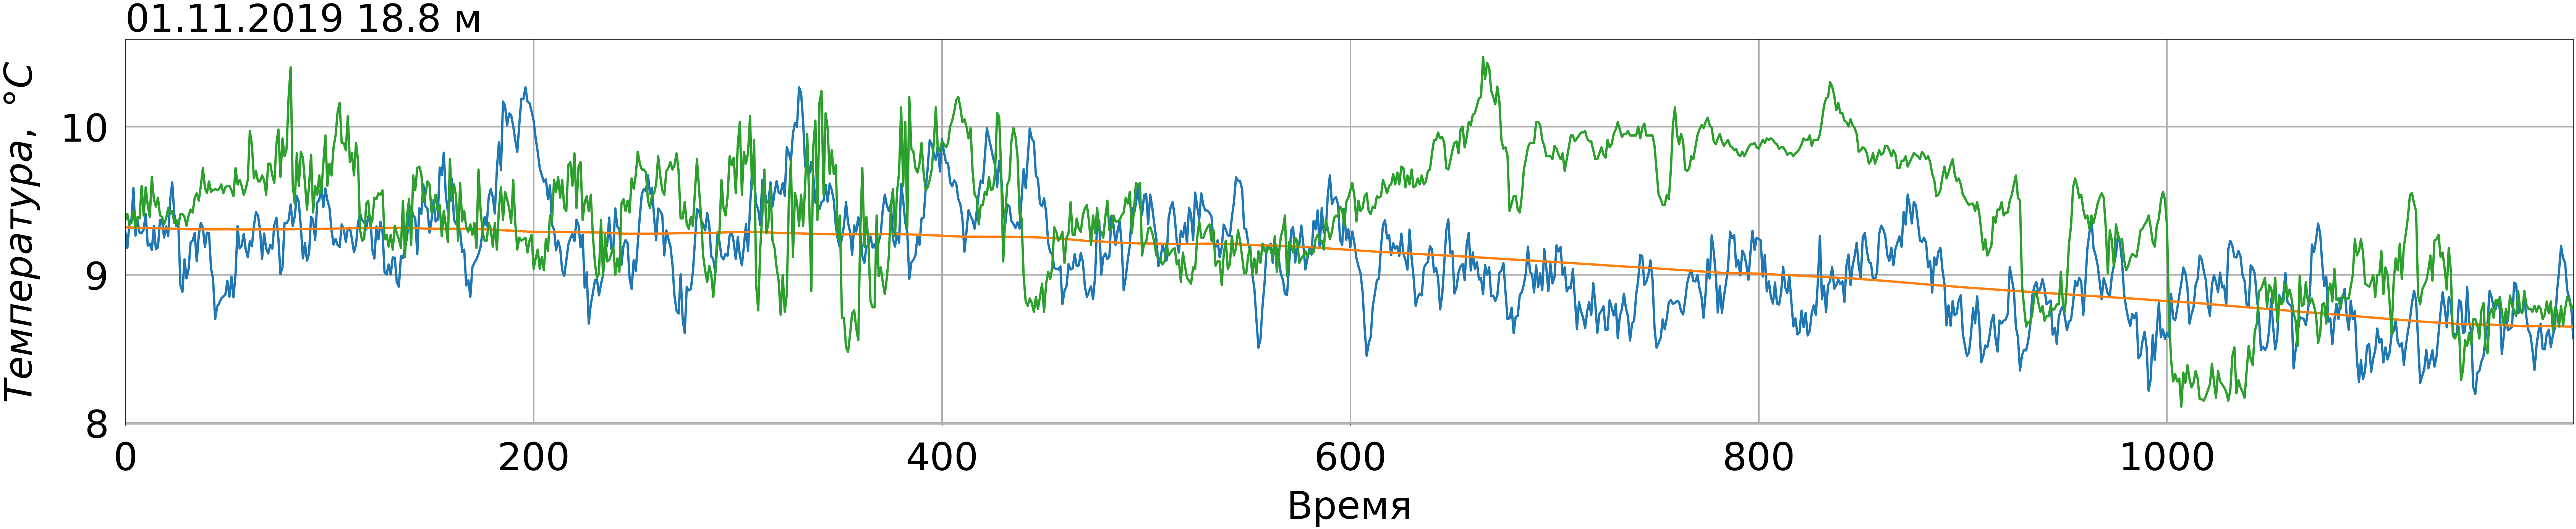

In [22]:
fig, ax1 = plt.subplots(figsize=(100, 20))

#plt.plot(T_gaus[2000:2200], linewidth=4)
#plt.plot(T_gap)

plt.plot(T_walk[1200:2400], linewidth=6)
#plt.plot(T_lin)
#plt.plot(T_ma_gaus[1200:2400], linewidth=6)
plt.plot(T_ma[1200:2400], linewidth=6)
plt.plot(T[1200:2400], linewidth=6)

ax1.tick_params(axis='both', labelsize=100, pad=40.0)
ax1.set_title('01.11.2019 18.8 м', fontsize=100, loc='left')
ax1.set_ylabel('$Температура,$ $°С$', fontsize=100, labelpad=50)
ax1.set_xlabel('Время', fontsize=100, labelpad=30)
#ax1.legend(loc='upper left', fontsize=75)
ax1.grid(linewidth=4)
ax1.margins(x=0)
plt.subplots_adjust(left=0.07, bottom=0.2, right=0.96, top=0.90)


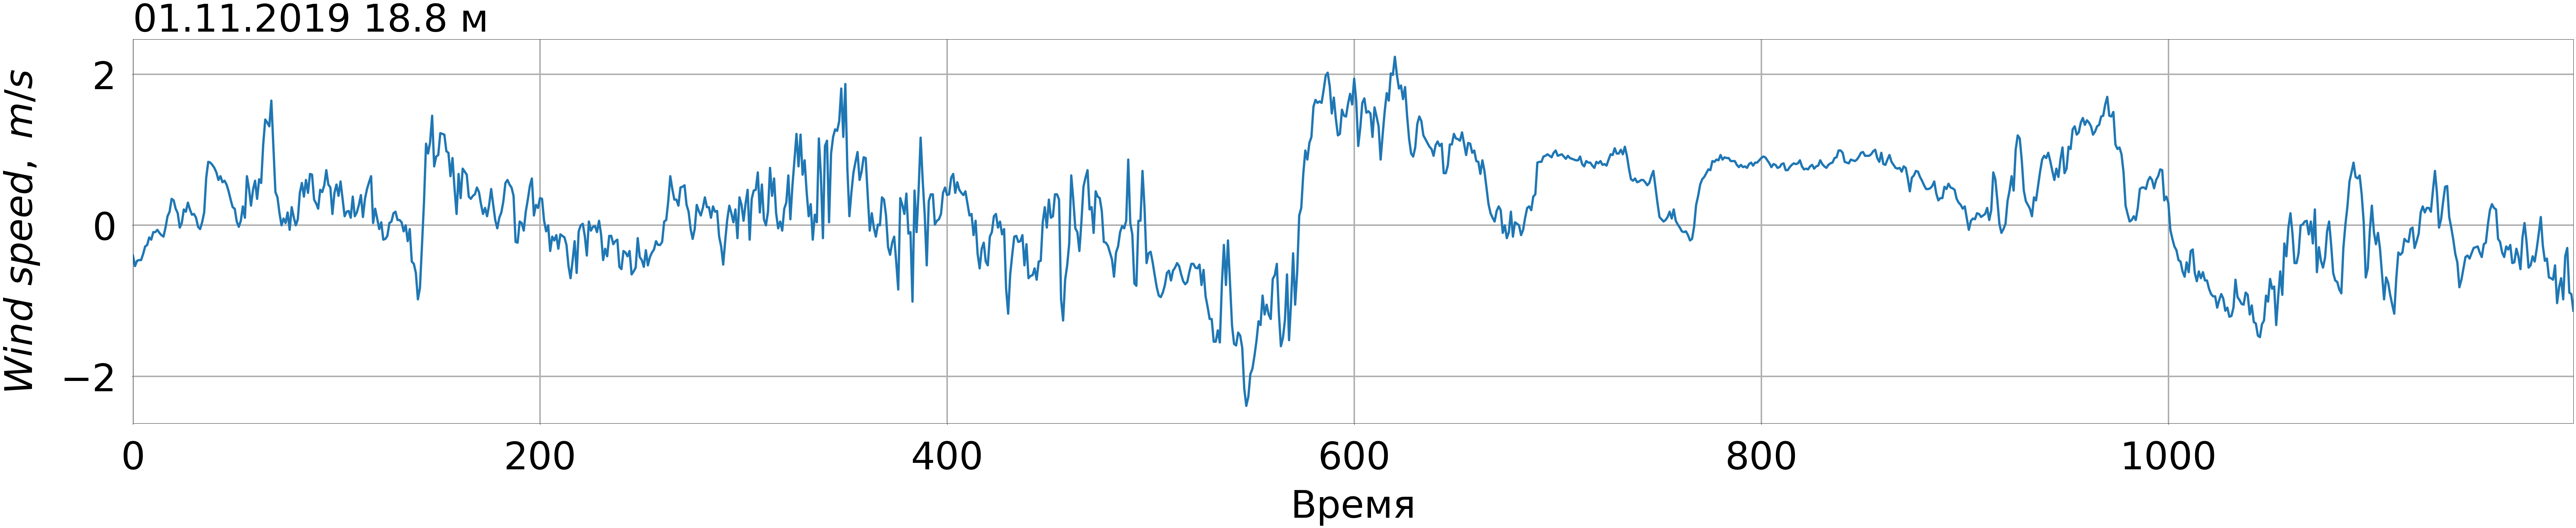

In [106]:
fig, ax1 = plt.subplots(figsize=(100, 20))
#plt.plot(T_walk[1200:2400], linewidth=6)
#plt.plot(T_lin)
#plt.plot(T_ma_gaus)
#plt.plot(T_ma[1200:2400], linewidth=6)
plt.plot(W[1200:2400], linewidth=6)

ax1.tick_params(axis='both', labelsize=100, pad=40.0)
ax1.set_title('01.11.2019 18.8 м', fontsize = 100,loc='left')
ax1.set_ylabel('$Wind$ $speed,$ $m/s$', fontsize=100, labelpad=50)
ax1.set_xlabel('Время', fontsize=100, labelpad=30)
#ax1.legend(loc='upper left', fontsize=75)
ax1.grid(linewidth=4)
ax1.margins(x=0)
plt.subplots_adjust(left=0.07, bottom=0.2, right=0.96, top=0.90)


array([[1.        , 0.93722385],
       [0.93722385, 1.        ]])

In [20]:
sg=1200
eg=1600

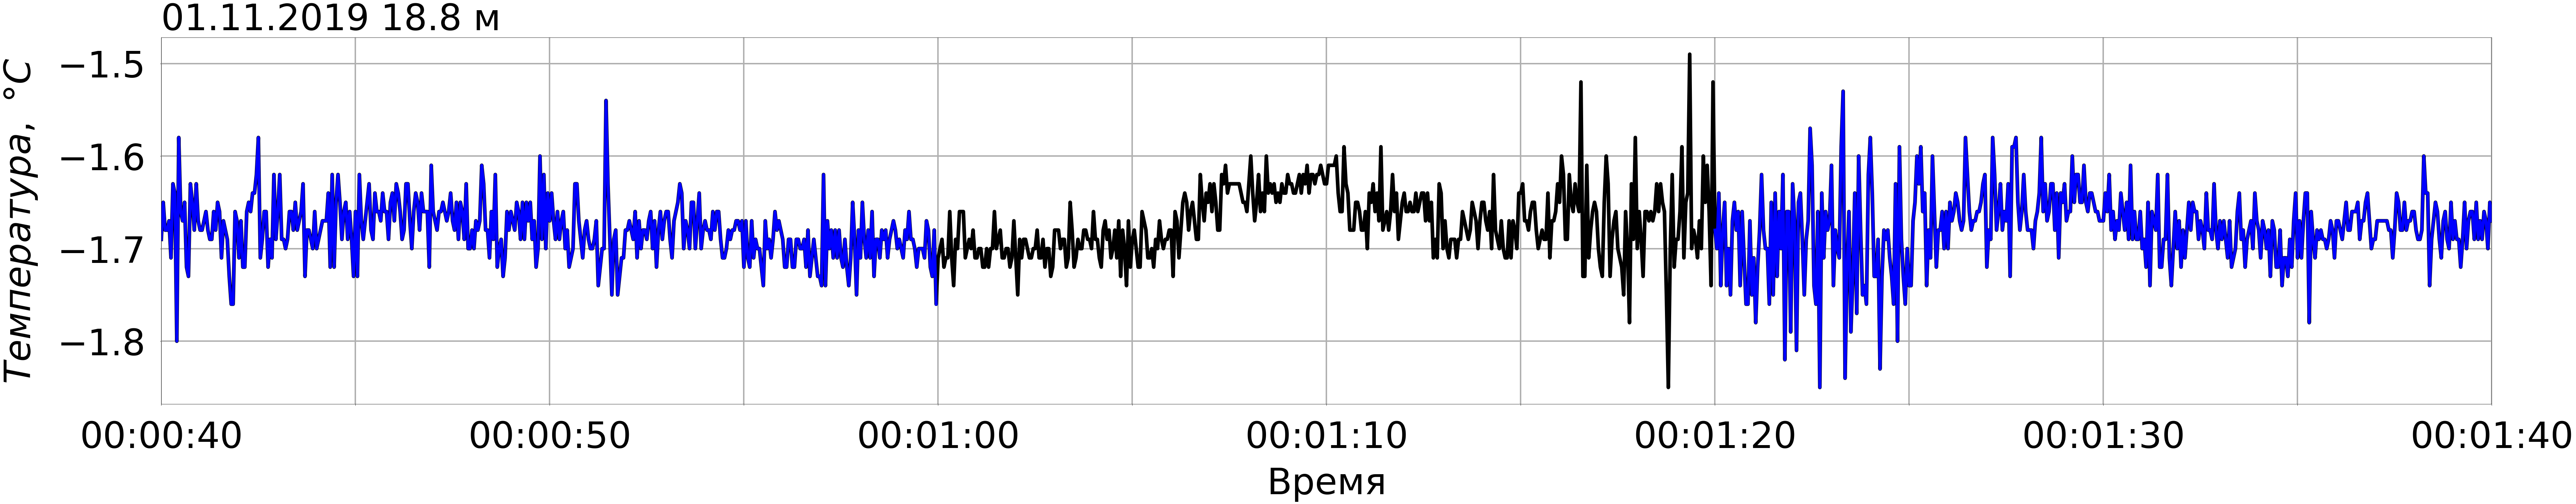

In [21]:
#data1=data.interpolate(method='linear', limit_area='inside')# линейная интерполяция пропусков
fig1, ax1=plt.subplots(figsize=(100, 20))
ax1.plot(try_data[9][sg-400-1:eg+401-1].values, label='', linewidth=10, color='k')
ax1.plot(data[9][sg-400:eg+401].values, label='', linewidth=8, color='b')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax1.set_xticklabels(['0','00:00:40','','00:00:50','','00:01:00','','00:01:10',
                     '','00:01:20','','00:01:30','','00:01:40'])
ax1.tick_params(axis='both', labelsize=100, pad=40.0)
ax1.set_title('01.11.2019 18.8 м', fontsize = 100,loc='left')
ax1.set_ylabel('$Температура,$ $°С$', fontsize=100, labelpad=50)
ax1.set_xlabel('Время', fontsize=100, labelpad=30)
#ax1.legend(loc='upper left', fontsize=75)
ax1.grid(linewidth=4)
ax1.margins(x=0)
plt.subplots_adjust(left=0.07, bottom=0.2, right=0.96, top=0.90)
#figure = Figure(facecolor="None")
fig1.savefig('C:\TOWER_DATA\TEST\gaps_T.jpg')

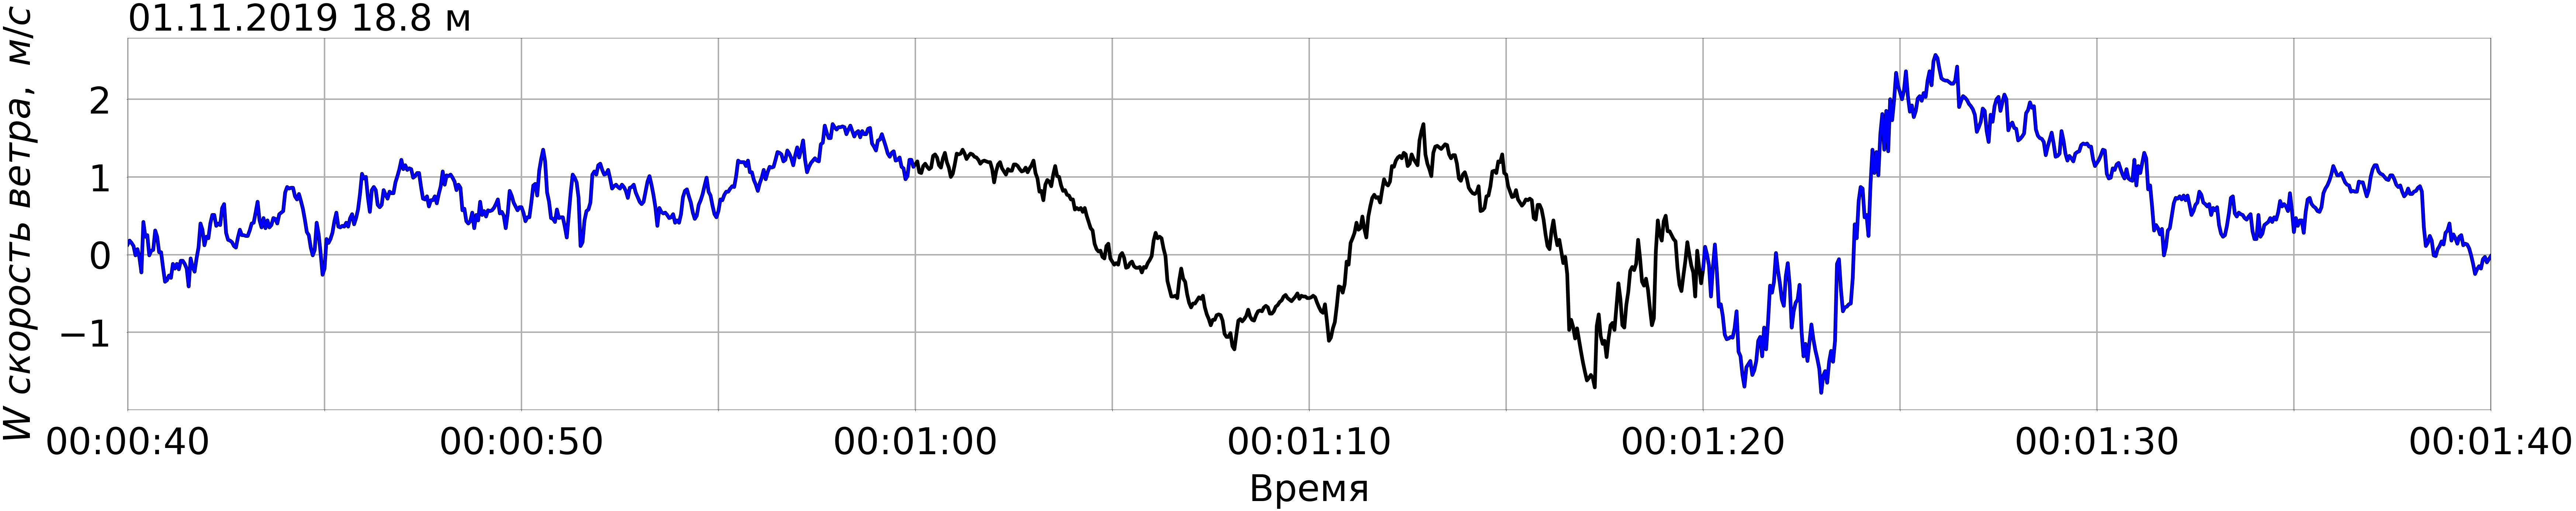

In [22]:
#data1=data.interpolate(method='linear', limit_area='inside')# линейная интерполяция пропусков
fig1, ax1=plt.subplots(figsize=(100, 20))
ax1.plot(try_data[7][sg-400-1:eg+401-1].values, label='', linewidth=10, color='k')
ax1.plot(data[7][sg-400:eg+401].values, label='', linewidth=8, color='b')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax1.set_xticklabels(['0','00:00:40','','00:00:50','','00:01:00','','00:01:10',
                     '','00:01:20','','00:01:30','','00:01:40'])
ax1.tick_params(axis='both', labelsize=100, pad=40.0)
ax1.set_title('01.11.2019 18.8 м', fontsize = 100,loc='left')
ax1.set_ylabel('$W$ $cкорость$ $ветра,$ $м/с$', fontsize=100, labelpad=50)
ax1.set_xlabel('Время', fontsize=100, labelpad=30)
#ax1.legend(loc='upper left', fontsize=75)
ax1.grid(linewidth=4)
ax1.margins(x=0)
plt.subplots_adjust(left=0.07, bottom=0.2, right=0.96, top=0.90)
#figure = Figure(facecolor="None")
fig1.savefig('C:\TOWER_DATA\TEST\gaps_W.jpg')

In [23]:
data1.loc[np.arange(sg,eg),[9,7]].cov()[9][9]

0.0017829348370927334

In [24]:
#открываем файлы для результата записи тестов
f1=open(r'C:\TOWER_DATA\TEST\Lin_int.csv','w')
f2=open(r'C:\TOWER_DATA\TEST\Gauss.csv','w')
f3=open(r'C:\TOWER_DATA\TEST\Cor_Gauss.csv','w')

#записываем шапки в файлы
f1.write('%8s,%8s,%8s,%8s,%8s,%8s,%8s,%8s,%8s,%8s,%8s,%8s\n'%('mean_T', 'mean_W', 'max_T', 'max_W', 'min_T', 'min_W', 'std_T', 'std_W', 'cov_TT', 'cov_WW', 'cov_TW', 'cor_TW'))
f2.write('%8s,%8s,%8s,%8s,%8s,%8s,%8s,%8s,%8s,%8s,%8s,%8s\n'%('mean_T', 'mean_W', 'max_T', 'max_W', 'min_T', 'min_W', 'std_T', 'std_W', 'cov_TT', 'cov_WW', 'cov_TW', 'cor_TW'))
f3.write('%8s,%8s,%8s,%8s,%8s,%8s,%8s,%8s,%8s,%8s,%8s,%8s\n'%('mean_T', 'mean_W', 'max_T', 'max_W', 'min_T', 'min_W', 'std_T', 'std_W', 'cov_TT', 'cov_WW', 'cov_TW', 'cor_TW'))

data1=data.copy()
# метод 1
data1[9][sg:eg]=np.linspace(data1[9][sg-(eg-sg):sg].mean(),data1[9][eg:eg+(eg-sg)].mean(),eg-sg)
data1[7][sg:eg]=np.linspace(data1[7][sg-(eg-sg):sg].mean(),data1[7][eg:eg+(eg-sg)].mean(),eg-sg)

#статистические характеристики первого метода
cov_TT=data1.loc[np.arange(sg,eg),[9,7]].cov()[9][9]
cov_WW=data1.loc[np.arange(sg,eg),[9,7]].cov()[7][7]
cov_TW=data1.loc[np.arange(sg,eg),[9,7]].cov()[9][7]
cor_TW=data1.loc[np.arange(sg,eg),[9,7]].corr(method='pearson')[9][7]
std_T=data1[9][sg:eg].std()
std_W=data1[7][sg:eg].std()
mean_T=data1[9][sg:eg].mean()
mean_W=data1[7][sg:eg].mean()
max_T=data1[9][sg:eg].max()
max_W=data1[7][sg:eg].max()
min_T=data1[9][sg:eg].min()
min_W=data1[7][sg:eg].min()

f1.write('%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f\n'%(mean_T, mean_W, max_T, max_W, min_T, min_W, std_T, std_W, cov_TT, cov_WW, cov_TW, cor_TW))
f1.close()

data2=data1.copy()
data3=data1.copy()
std_T=data[9][sg-(eg-sg):eg+(eg-sg)].std()
std_W=data[7][sg-(eg-sg):eg+(eg-sg)].std()
cov=data.loc[np.arange(sg-(eg-sg),eg+(eg-sg)),[9,7]].cov()
for i in range(10):
    for i in range(sg,eg):
        #метод 2
        data2[9][i]=np.random.normal(data1[9][i], std_T)
        data2[7][i]=np.random.normal(data1[7][i], std_W)    
        #метод 3
        data3[9][i],data3[7][i]=np.random.multivariate_normal((data1[9][i],data1[7][i]), cov)
    
    cov_TT=data2.loc[np.arange(sg,eg),[9,7]].cov()[9][9]
    cov_WW=data2.loc[np.arange(sg,eg),[9,7]].cov()[7][7]
    cov_TW=data2.loc[np.arange(sg,eg),[9,7]].cov()[9][7]
    cor_TW=data2.loc[np.arange(sg,eg),[9,7]].corr(method='pearson')[9][7]
    std_T=data2[9][sg:eg].std()
    std_W=data2[7][sg:eg].std()
    mean_T=data2[9][sg:eg].mean()
    mean_W=data2[7][sg:eg].mean()
    max_T=data2[9][sg:eg].max()
    max_W=data2[7][sg:eg].max()
    min_T=data2[9][sg:eg].min()
    min_W=data2[7][sg:eg].min()
    
    f2.write('%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f\n'%(mean_T, mean_W, max_T, max_W, min_T, min_W, std_T, std_W, cov_TT, cov_WW, cov_TW, cor_TW))

    cov_TT=data3.loc[np.arange(sg,eg),[9,7]].cov()[9][9]
    cov_WW=data3.loc[np.arange(sg,eg),[9,7]].cov()[7][7]
    cov_TW=data3.loc[np.arange(sg,eg),[9,7]].cov()[9][7]
    cor_TW=data3.loc[np.arange(sg,eg),[9,7]].corr(method='pearson')[9][7]
    std_T=data3[9][sg:eg].std()
    std_W=data3[7][sg:eg].std()
    mean_T=data3[9][sg:eg].mean()
    mean_W=data3[7][sg:eg].mean()
    max_T=data3[9][sg:eg].max()
    max_W=data3[7][sg:eg].max()
    min_T=data3[9][sg:eg].min()
    min_W=data3[7][sg:eg].min()
    f3.write('%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f,%8.3f\n'%(mean_T, mean_W, max_T, max_W, min_T, min_W, std_T, std_W, cov_TT, cov_WW, cov_TW, cor_TW))

f2.close()
f3.close()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats i

In [41]:
Cor_Gauss=pd.read_csv(r'C:/TOWER_DATA/TEST/Cor_Gauss.csv', delimiter=',',skipinitialspace=True, comment='#')


In [53]:
Cor_Gauss['mean_W'][:].mean()

0.6695

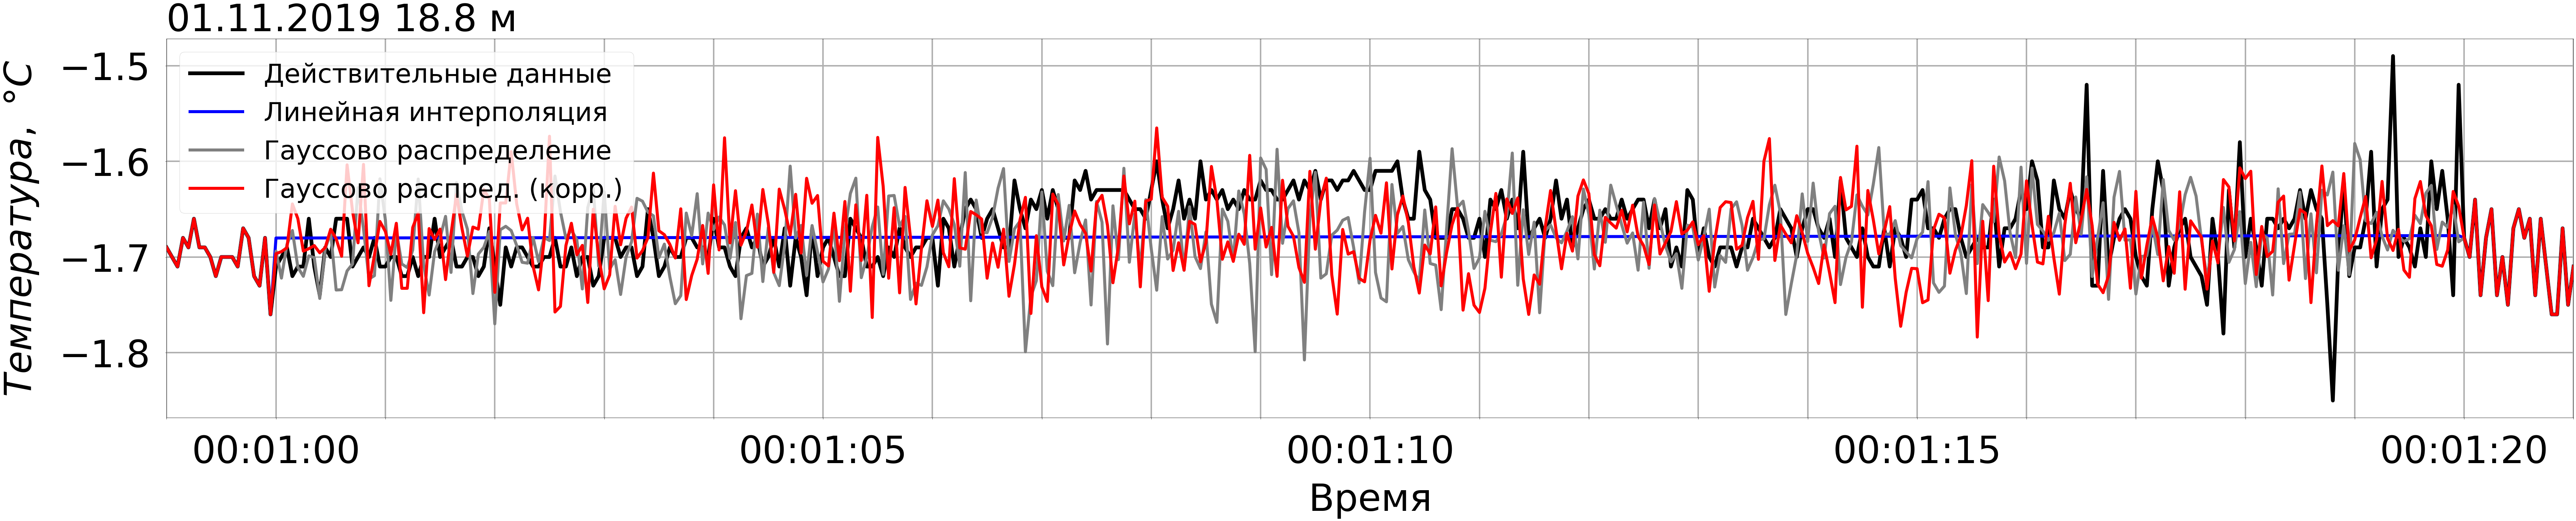

In [76]:
#data1=data.interpolate(method='linear', limit_area='inside')# линейная интерполяция пропусков
fig1, ax1=plt.subplots(figsize=(100, 20))
ax1.plot(try_data[9][sg-20-1:eg+21-1].values, label='Действительные данные', linewidth=10, color='k')
ax1.plot(data1[9][sg-20:eg+21].values, label='Линейная интерполяция', linewidth=8, color='b')
ax1.plot(data2[9][sg-20:eg+21].values, label='Гауссово распределение', linewidth=8, color='gray')
ax1.plot(data3[9][sg-20:eg+21].values, label='Гауссово распред. (корр.)', linewidth=8, color='r')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax1.set_xticklabels(['0','','00:01:00','','','','','00:01:05','','','','','00:01:10',
                     '','','','','00:01:15','','','','','00:01:20'])
ax1.tick_params(axis='both', labelsize=100, pad=40.0)
ax1.set_title('01.11.2019 18.8 м', fontsize = 100,loc='left')
ax1.set_ylabel('$Температура,$ $°С$', fontsize=100, labelpad=50)
ax1.set_xlabel('Время', fontsize=100, labelpad=30)
ax1.legend(loc='upper left', fontsize=70)
ax1.grid(linewidth=4)
ax1.margins(x=0)
plt.subplots_adjust(left=0.07, bottom=0.2, right=0.96, top=0.90)
#figure = Figure(facecolor="None")
fig1.savefig('C:\TOWER_DATA\TEST\gaps_T_20sec.jpg')

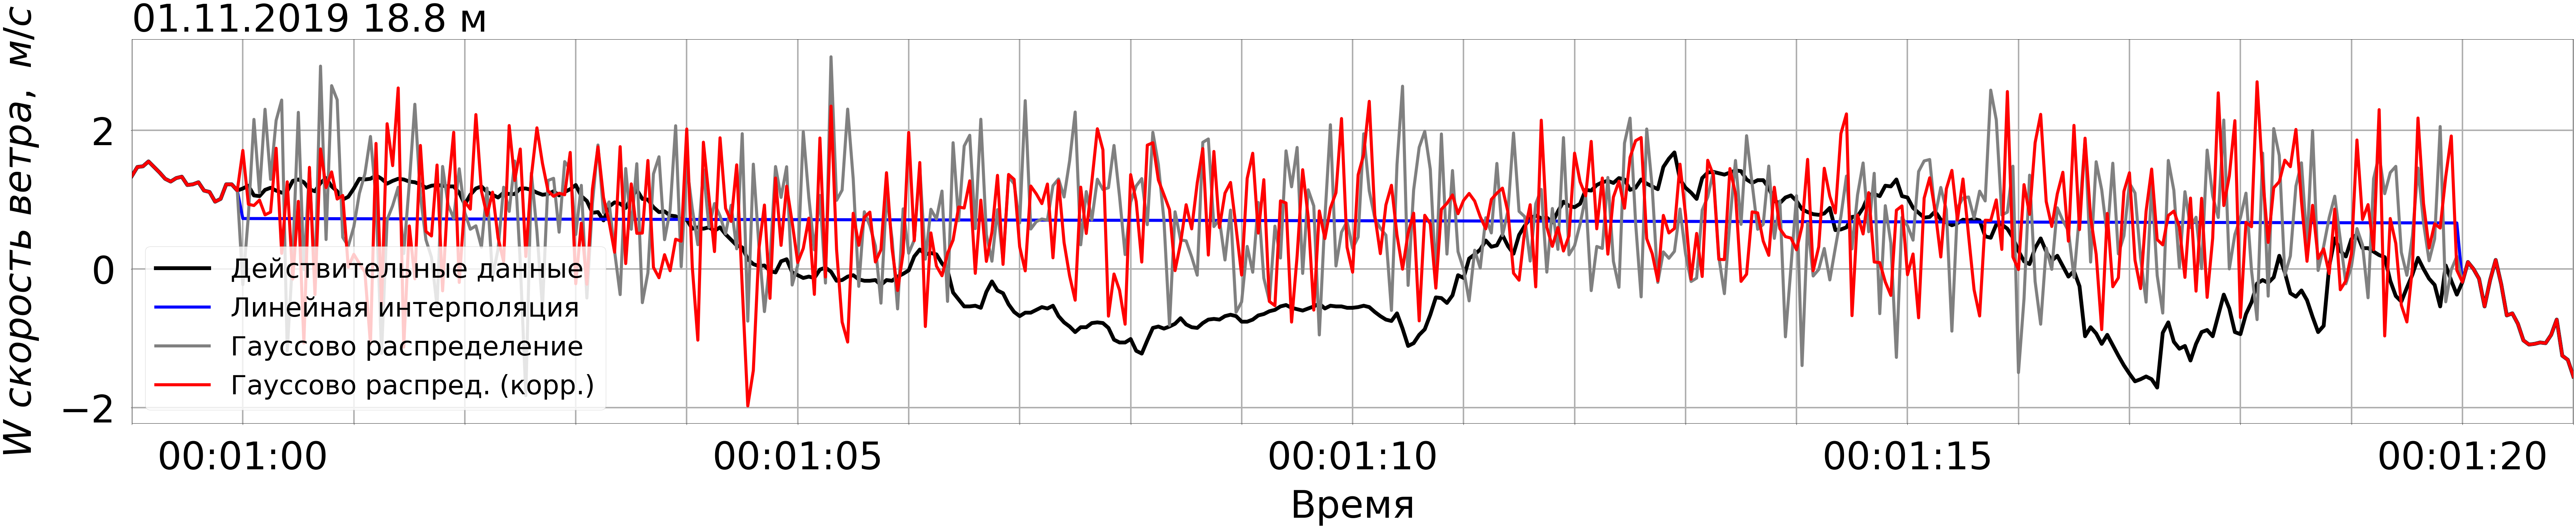

In [75]:
#data1=data.interpolate(method='linear', limit_area='inside')# линейная интерполяция пропусков
fig1, ax1=plt.subplots(figsize=(100, 20))
ax1.plot(try_data[7][sg-20-1:eg+21-1].values, label='Действительные данные', linewidth=10, color='k')
ax1.plot(data1[7][sg-20:eg+21].values, label='Линейная интерполяция', linewidth=8, color='b')
ax1.plot(data2[7][sg-20:eg+21].values, label='Гауссово распределение', linewidth=8, color='gray')
ax1.plot(data3[7][sg-20:eg+21].values, label='Гауссово распред. (корр.)', linewidth=8, color='r')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax1.set_xticklabels(['0','','00:01:00','','','','','00:01:05','','','','','00:01:10',
                     '','','','','00:01:15','','','','','00:01:20'])
ax1.tick_params(axis='both', labelsize=100, pad=40.0)
ax1.set_title('01.11.2019 18.8 м', fontsize = 100,loc='left')
ax1.set_ylabel('$W$ $скорость$ $ветра,$ $м/с$', fontsize=100, labelpad=50)
ax1.set_xlabel('Время', fontsize=100, labelpad=30)
ax1.legend(loc='best', fontsize=70)
ax1.grid(linewidth=4)
ax1.margins(x=0)
plt.subplots_adjust(left=0.07, bottom=0.2, right=0.96, top=0.90)
#figure = Figure(facecolor="None")
fig1.savefig('C:\TOWER_DATA\TEST\gaps_W_20sec.jpg')

In [55]:
try_data[7][sg-1:eg-1].mean()

#data1.loc[np.arange(sg,eg),[9,7]].cov()

0.21652499999999988

In [21]:
iNan=data[9].index[data[9].isna()].tolist()
iNan=[-2]+iNan

In [22]:
len_gap=1
LNan=[]
INan=[]
for i in np.arange(len(iNan)-1,0,-1):
    if iNan[i]-1==iNan[i-1]:
        len_gap+=1
    else:
        INan.append(iNan[i])
        LNan.append(len_gap)
        len_gap=1
len(LNan)

172

In [23]:
T=data[9][0:500].values
W=data[7][0:500].values

In [60]:
data1=data.interpolate(method='linear', limit_area='inside')
W1=data1[7][0:500].values
T1=data1[9][0:500].values

In [81]:
data2=data1.copy()
for i in range(len(INan)-2,len(INan)): 
    if LNan[i]>1200: 
        print(INan, LNan)
        continue
    s=min(INan[i]-LNan[i],INan[i]-30)
    if s<0:
        e=max(INan[i]+LNan[i]+LNan[i],INan[i]+LNan[i]+30)
        stdW=data2[7][INan[i]+LNan[i]:e].std()
        stdT=data2[9][INan[i]+LNan[i]:e].std()
    else:
        stdW=data2[7][s:INan[i]].std()
        stdT=data2[9][s:INan[i]].std()
    for j in range(INan[i],INan[i]+LNan[i]):
            data2[7][j]+=np.random.normal(0, stdW)
            data2[9][j]+=np.random.normal(0, stdT)

W2=data2[7][0:500].values
T2=data2[9][0:500].values       

0.47120945327067126 0.16506247524032924


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924
0.47120945327067126 0.16506247524032924


19    0.796912
Name: 7, dtype: float64
nan


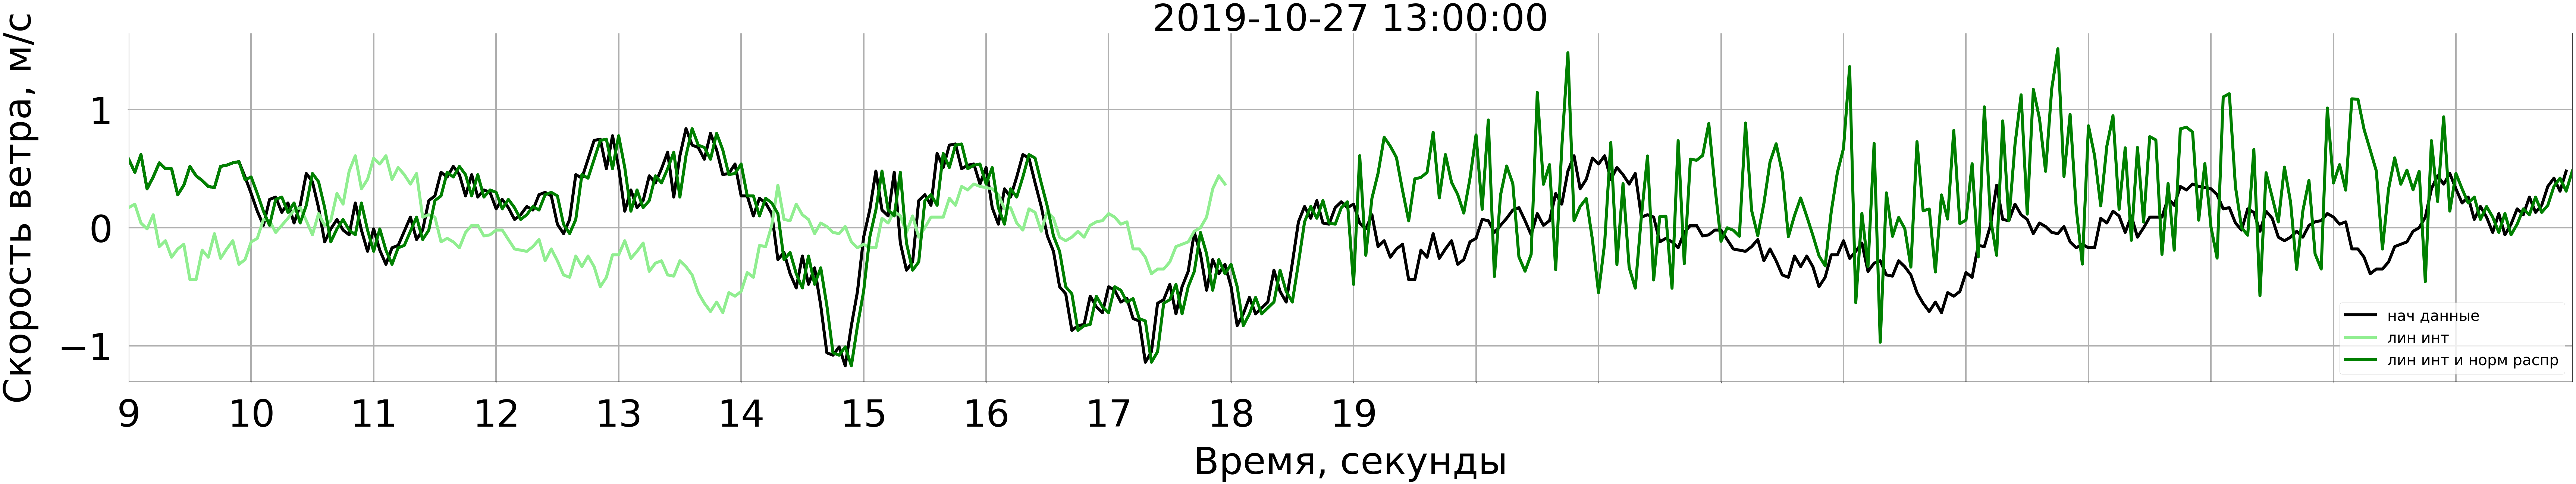

In [63]:
fig1, ax1=plt.subplots(figsize=(100, 20))

ax1.plot(f[7][0:399].values, label='нач данные', linewidth=8,color='black') #yellowgreen
ax1.plot(W1[0:400], label='лин инт', linewidth=8,color='lightgreen')
ax1.plot(W2[0:400], label='лин инт и норм распр', linewidth=8,color='green')

ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax1.set_xticklabels(np.arange(8,20))
ax1.tick_params(axis='both', labelsize=100, pad=40.0)
ax1.set_title(data[0][0],fontsize = 100)
ax1.set_ylabel('Скорость ветра, м/с',fontsize=100, labelpad=50) #Температура, °С
ax1.set_xlabel('Время, секунды',fontsize=100, labelpad=30)
ax1.grid(linewidth=4)
ax1.margins(x=0)
ax1.legend(loc='lower right', fontsize=40)

margins = {
    "left"   : 0.070,
    "bottom" : 0.200,
    "right"  : 0.980,
    "top"    : 0.850   
}

#figure = Figure(facecolor="None")
fig1.subplots_adjust(**margins)   

In [82]:
W2=f[7][199:379].values
W1=f[7][0:199].values
print(np.std(W1),np.std(W2))

0.46767135042439534 0.26423270584752784


In [61]:
f=pd.read_csv(input_directory+'/'+'191027130000.dat', sep='\s+', usecols=[0,3,5,7,9], comment='#', header=None)
W1=f[7][199:379].values
T1=f[9][199:379].values
print(np.min(W1),np.min(T1),
      np.max(W1),np.max(T1),
      np.average(W1),np.average(T1),
      np.std(W1),np.std(T1),
      np.median(W1),np.median(T1),
      np.corrcoef(W1,T1))
print (np.std(W1[0:200]),np.std(T1[0:200]))


-0.72 12.71 0.61 13.61 -0.043722222222222225 13.072944444444445 0.26423270584752784 0.16915376706884253 -0.04 13.07 [[ 1.         -0.11369748]
 [-0.11369748  1.        ]]
0.26423270584752784 0.16915376706884253


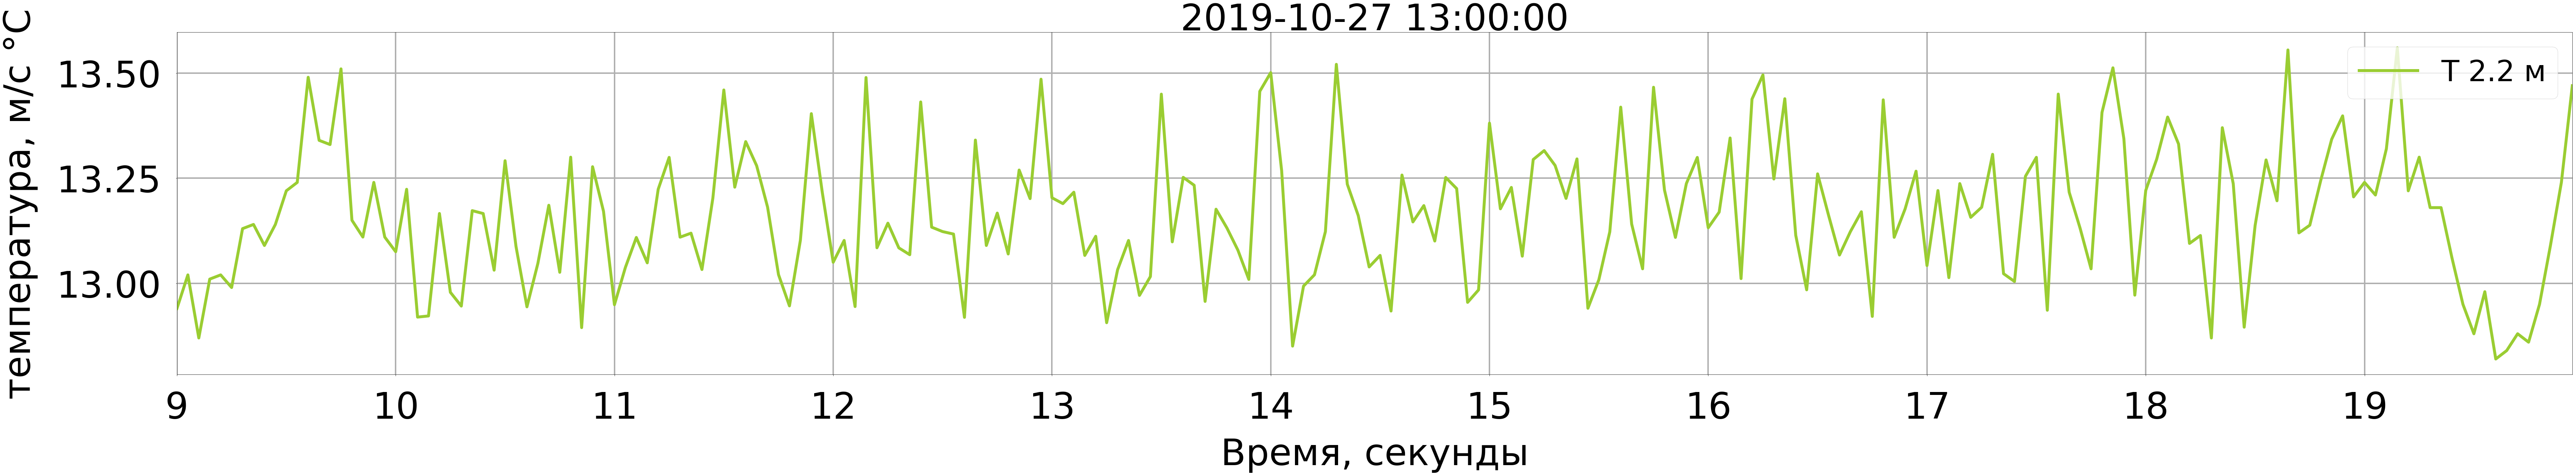

In [65]:
fig1, ax1=plt.subplots(figsize=(100, 20))
ax1.plot(data[9][180:400], label='T 2.2 м', linewidth=8,color='yellowgreen')
ax1.plot(data[7][180:400], label='W 2.2 м', linewidth=8,color='green')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax1.set_xticklabels(np.arange(8,20))
ax1.tick_params(axis='both', labelsize=100, pad=40.0)
ax1.set_title(data[0][0],fontsize = 100)
ax1.set_ylabel('температура, м/с °С',fontsize=100, labelpad=50) #Температура, °С
ax1.set_xlabel('Время, секунды',fontsize=100, labelpad=30)
ax1.grid(linewidth=4)
ax1.margins(x=0)
ax1.legend(loc='best', fontsize=80)

margins = {
    "left"   : 0.070,
    "bottom" : 0.200,
    "right"  : 0.980,
    "top"    : 0.850   
}

#figure = Figure(facecolor="None")
fig1.subplots_adjust(**margins)   

In [93]:
input_directory=r'C:\TOWER_DATA\2019 - Copy\frank\191109'   #местоположение данных
output_directory=r'C:\TOWER_DATA\DATA_SORT\frank\191109'
files=os.listdir(input_directory)   #файлы в папке
#data=pd.read_csv(input_directory+'\\'+files[0], delimiter=' ', skipinitialspace=True, usecols=np.arange(10), comment='#', header=None)
for file_name in files: 
    data=pd.read_csv(input_directory+'\\'+file_names, delimiter=' ', skipinitialspace=True, usecols=np.arange(10), comment='#', header=None)
    data=data.sort_values(0, kind='mergesort')
    data.to_csv(output_directory+'\\'+file_name[:-3]+'csv', sep=' ', header=None)

In [58]:
data=pd.concat([data1, data2])

In [85]:
data=pd.read_csv(input_directory+'\\'+files[0], delimiter=' ', skipinitialspace=True, usecols=np.arange(10), comment='#', header=None)

In [57]:
input_directory=r'C:\TOWER_DATA\2019\frank'   #местоположение данных
folders=os.listdir(input_directory)   #файлы в папке
output_directory=r'C:\TOWER_DATA\DATA_GAPS\frank'
time_start=datetime(2019,10,27,13,00,00)
time_end=datetime(2019,11,1,00,00,00)


for folder_name in folders: 
    files=os.listdir(input_directory+'\\'+folder_name)
    for file_name in files:
        if 
        f_in=pd.read_csv(input_directory+'\\'+folder_name+'\\'+file_name,usecols=[0], delimiter=' ', comment='#', header=None)
        full_time=

SyntaxError: invalid syntax (<ipython-input-57-9ff413746345>, line 11)

In [38]:
data=pd.read_csv(r'C:\TOWER_DATA\2019\ifa\200607\200423090000.dat',usecols=[0], delimiter=' ', comment='#', header=None)
data[0]=data[0].astype(str)
data[0]=pd.to_datetime(data[0], errors='raise',format='%y%m%d%H%M%S')

sys.getsizeof(datetime.timestamp(data[0]))
data.reindex(data[0])


200423090000 200423090001
200423090059 200423090100
200423095959 200423100000
4041


## подсчет пропусков в старых данных L1

In [6]:
input_directory=r'C:\TOWER_DATA\2019\frank'   #местоположение данных
folders=os.listdir(input_directory)   #файлы в папке
output_directory=r'C:\TOWER_DATA\DATA_GAPS\frank'
time_start=datetime(2019,10,27,13,00,00)
time2=datetime.timestamp(time_start)
gap=[]
time_gap=[]
gap_full=[]
time_gap_full=[]
gap2=0
time_gap2=time2
delta_time2=0

j=-1

f_out_full=open(output_directory+'\\full_gaps.csv','w')
f_out_full.write('time'+', '+'gap'+'\n')

f_out=open(output_directory+'\\gaps.csv','w')
f_out.write('time'+', '+'gap'+'\n')

for folder_name in folders: 
    files=os.listdir(input_directory+'\\'+folder_name)
    for file_name in files:
        f_in=open(input_directory+'\\'+folder_name+'\\'+file_name)
        for line in f_in:
            line=line.split()
            time1=time2 #time1 = предыдущее значение по времени
            try: #если значение не соответствует формату, или строчка слишком короткая, спускаемся в except 
                assert len(line)==10 #проверяем на пустые значения, если они есть спускаемся в except
                time2=datetime.timestamp(datetime.strptime(line[0],'%y%m%d%H%M%S')) #time2 = текущее значение по времени
            except(ValueError,IndexError, AssertionError):
                if len(line)==6 and len(line[0])==12:
                    time2=datetime.timestamp(datetime.strptime(line[0],'%y%m%d%H%M%S'))
                else:
                    print(line)
                    continue                   
                       
            j+=1 #считаем только нормальные значения
            if time2!=time1: #если текущее значение не равно предыдущему, считаем их разницу
                delta_time=time2-time1
                if delta_time!=1 or j!=20: #критерий пропуска: разница между значениями не равна 1 секунде и/или значений с предыдущем индексом по времени не 20
                    f_out_full.write(str(datetime.fromtimestamp(time1))+', '+str((delta_time-1)*20+20-j)+'\n')#записываем время и длину пропуска в файл
                    #далее идет сортировка, пропуски равные по модулю и противоположные по знаку, идущие сразу друг за другом, не учитываются 
                    gap1=gap2 #длина предыдущего пропуска
                    gap2=(delta_time-1)*20+20-j #длина текущего пропуска
                    time_gap1=time_gap2 #время предыдущего пропуска
                    time_gap2=time1 #время ткущего пропуска
                    delta_time1=delta_time2 #разница между текущим временным индексом и предыдущим для прошлого пропуска
                    delta_time2=delta_time #разница между текущим временным индексом и предыдущим для текущего пропуска
                    #Если после предыдущего пропуска сразу идет текущий пропуск с противоположным знаком и равный по модулю, он не учитывается
                    if gap1!=0 and (time_gap2-time_gap1!=delta_time1 or gap1!=-(gap2)): 
                        '''Если после предыдущего пропуска сразу идет текущий пропуск
                        с противоположным знаком, но отличающийся по модулю, они складываются'''
                        if (time_gap2-time_gap1==delta_time1 and gap1>0 and gap2<0) or (
                            time_gap2-time_gap1==delta_time1 and gap1<0 and gap2>0):
                            gap2=gap1+gap2
                        else:
                            '''Если после предыдущего пропуска не сразу идет текущий пропуск
                            или сразу, но с тем же знаком, записывается ПРЕДЫДУЩИЙ пропуск'''
                            gap.append(gap1)
                            time_gap.append(datetime.fromtimestamp(time_gap1))
                            f_out.write(str(datetime.fromtimestamp(time_gap1))+', '+str(gap1)+'\n')
                j=0
        f_in.close()

gap.append(gap2)
time_gap.append(datetime.fromtimestamp(time_gap2))
f_out_full.write(str(datetime.fromtimestamp(time_gap2))+', '+str(gap2)+'\n')
f_out.write(str(datetime.fromtimestamp(time_gap2))+', '+str(gap2)+'\n')
f_out.close()
f_out_full.close()

f_out_total=open(output_directory+'\\total_gaps.csv','w')
f_out_total.write('length_gap'+', '+'counts_gap'+'\n')
length,counts=np.unique(gap, return_counts=True)
for i in range(len(length)):
    f_out_total.write(str(length[i])+', '+str(counts[i])+'\n')
f_out_total.close()    
print(length, counts)

['191109160330', 'PST', 'SNC', '210419033725', 'UTC', 'S', 'O', 'N', 'I', 'C', '-', 'A', 'n', 'e', 'm', 'o', 'm', 'e', 't', 'e', 'r', 'USA-1/T']
['191109160330', 'PST']
['191109160333', 'PST', 'x=', '-1.56', 'y=', '-0\x0eSNC', '210419033729', 'UTC', 'S', 'O', 'N', 'I', 'C', '-', 'A', 'n', 'e', 'm', 'o', 'm', 'e', 't', 'e', 'r', 'USA-1/T']
['191109160333', 'PST']
['191109160339', 'PST', 'x=', '-1SNC', '210419033734', 'UTC', 'S', 'O', 'N', 'I', 'C', '-', 'A', 'n', 'e', 'm', 'o', 'm', 'e', 't', 'e', 'r', 'USA-1/T']
['191109160339', 'PST']
['191109160342', 'PST', 'x=', '-0.51', 'y=', '0.43', 'z=', '0.31', 'T=']
['191109160357', 'PST', 'x=', 'ÀÀSNC', '210419033752', 'UTC', 'S', 'O', 'N', 'I', 'C', '-', 'A', 'n', 'e', 'm', 'o', 'm', 'e', 't', 'e', 'r', 'USA-1/T']
['191109160357', 'PST']
['191109160359', 'PST', 'SNC', '210419033754', 'UTC', 'S', 'O', 'N', 'I', 'C', '-', 'A', 'n', 'e', 'm', 'o', 'm', 'e', 't', 'e', 'r', 'USA-1/T']
['191109160359', 'PST']
['191109160401', 'PST', 'SNC', '2104190

## подсчет пропусков в старых данных L2 

In [7]:
input_directory=r'C:\TOWER_DATA\2019\ifa'   #местоположение данных
folders=os.listdir(input_directory)   #файлы в папке
output_directory=r'C:\TOWER_DATA\DATA_GAPS\ifa' #место вывода данных
time_start=datetime(2019,10,27,13,00,00)
time2=datetime.timestamp(time_start)
gap=[]
time_gap=[]
gap_full=[]
time_gap_full=[]
gap2=0
time_gap2=time2
delta_time2=0

j=-1

f_out_full=open(output_directory+'\\full_gaps.csv','w')
f_out_full.write('time'+', '+'gap'+'\n')

f_out=open(output_directory+'\\gaps.csv','w')
f_out.write('time'+', '+'gap'+'\n')

for folder_name in folders: 
    files=os.listdir(input_directory+'\\'+folder_name)
    for file_name in files:
        f_in=open(input_directory+'\\'+folder_name+'\\'+file_name)
        for line in f_in:
            line=line.split()
            time1=time2 #time1 = предыдущее значение по времени
            try: #если значение не соответствует формату, или строчка слишком короткая, спускаемся в except 
                if line[2]=='E:invalid': continue #строки с коментарием не обрабатываются
                assert len(line)==14  #проверяем на пустые значения, если они есть спускаемся в except
                time2=datetime.timestamp(datetime.strptime(line[0],'%y%m%d%H%M%S')) #time2 = текущее значение по времени
            except(ValueError,IndexError, AssertionError):
                if len(line)==10 and len(line[0])==12:
                    time2=datetime.timestamp(datetime.strptime(line[0],'%y%m%d%H%M%S'))
                else:
                    print(line)
                    continue                   
                       
            j+=1 #считаем только нормальные значения
            if time2!=time1: #если текущее значение не равно предыдущему, считаем их разницу
                delta_time=time2-time1
                if delta_time!=1 or j!=20: #критерий пропуска: разница между значениями не равна 1 секунде и/или значений с предыдущем индексом по времени не 20
                    f_out_full.write(str(datetime.fromtimestamp(time1))+', '+str((delta_time-1)*20+20-j)+'\n')#записываем время и длину пропуска в файл
                    #далее идет сортировка, пропуски равные по модулю и противоположные по знаку, идущие сразу друг за другом, не учитываются 
                    gap1=gap2 #длина предыдущего пропуска
                    gap2=(delta_time-1)*20+20-j #длина текущего пропуска
                    time_gap1=time_gap2 #время предыдущего пропуска
                    time_gap2=time1 #время ткущего пропуска
                    delta_time1=delta_time2 #разница между текущим временным индексом и предыдущим для прошлого пропуска
                    delta_time2=delta_time #разница между текущим временным индексом и предыдущим для текущего пропуска
                    #Если после предыдущего пропуска сразу идет текущий пропуск с противоположным знаком и равный по модулю, он не учитывается
                    if gap1!=0 and (time_gap2-time_gap1!=delta_time1 or gap1!=-(gap2)): 
                        '''Если после предыдущего пропуска сразу идет текущий пропуск
                        с противоположным знаком, но отличающийся по модулю, они складываются'''
                        if (time_gap2-time_gap1==delta_time1 and gap1>0 and gap2<0) or (
                            time_gap2-time_gap1==delta_time1 and gap1<0 and gap2>0):
                            gap2=gap1+gap2
                        else:
                            '''Если после предыдущего пропуска не сразу идет текущий пропуск
                            или сразу, но с тем же знаком, записывается ПРЕДЫДУЩИЙ пропуск'''
                            gap.append(gap1)
                            time_gap.append(datetime.fromtimestamp(time_gap1))
                            f_out.write(str(datetime.fromtimestamp(time_gap1))+', '+str(gap1)+'\n')
                j=0
        f_in.close()

gap.append(gap2)
time_gap.append(datetime.fromtimestamp(time_gap2))
f_out_full.write(str(datetime.fromtimestamp(time_gap2))+', '+str(gap2)+'\n')
f_out.write(str(datetime.fromtimestamp(time_gap2))+', '+str(gap2)+'\n')
f_out.close()
f_out_full.close()

f_out_total=open(output_directory+'\\total_gaps.csv','w')
f_out_total.write('length_gap'+', '+'counts_gap'+'\n')
length,counts=np.unique(gap, return_counts=True)
for i in range(len(length)):
    f_out_total.write(str(length[i])+', '+str(counts[i])+'\n')
f_out_total.close()    
print(length, counts)

['191109155608', 'PST', '\x02\x02\x02ŠÊ’j']
['191117104613', 'PST', 'M:x', '=', '-119', 'y', '=', '-183', 'z']
['191117121931', 'PST', 'M:x', '=', '-137', 'y', '=', '-110', 'z', '=', '-94']
['191209165238', 'PST', 'M:x', '=', '-316', 'y', '=', '-183']
['191225174006', 'PST', 'M:x', '=', '-91', 'y', '=', '-145', 'z', '=', '13', 't']
['200611102338', 'PDT', 'M:x', '=', '56', 'y', '=', '-125']
[-7.2000000e+04 -1.2010000e+03 -1.1960000e+03 -1.1930000e+03
 -7.9000000e+02 -7.1200000e+02 -6.9000000e+02 -5.9300000e+02
 -4.5500000e+02 -4.0600000e+02 -3.6800000e+02 -3.6700000e+02
 -3.6000000e+02 -3.1500000e+02 -1.7900000e+02 -1.7200000e+02
 -1.4700000e+02 -1.3800000e+02 -8.4000000e+01 -8.2000000e+01
 -8.0000000e+01 -6.9000000e+01 -6.4000000e+01 -6.2000000e+01
 -5.4000000e+01 -5.0000000e+01 -4.5000000e+01 -3.9000000e+01
 -3.6000000e+01 -3.4000000e+01 -3.0000000e+01 -2.2000000e+01
 -2.0000000e+01 -1.9000000e+01 -1.7000000e+01 -1.6000000e+01
 -1.5000000e+01 -1.4000000e+01 -1.3000000e+01 -1.1000000e

## подсчет пропусков в старых данных L3

In [8]:
input_directory=r'C:\TOWER_DATA\2019\io'   #местоположение данных
folders=os.listdir(input_directory)   #файлы в папке
output_directory=r'C:\TOWER_DATA\DATA_GAPS\io'
time_start=datetime(2019,10,27,13,00,00)
time2=datetime.timestamp(time_start)
gap=[]
time_gap=[]
gap_full=[]
time_gap_full=[]
gap2=0
time_gap2=time2
delta_time2=0

j=-1

f_out_full=open(output_directory+'\\full_gaps.csv','w')
f_out_full.write('time'+', '+'gap'+'\n')

f_out=open(output_directory+'\\gaps.csv','w')
f_out.write('time'+', '+'gap'+'\n')

for folder_name in folders: 
    files=os.listdir(input_directory+'\\'+folder_name)
    for file_name in files:
        f_in=open(input_directory+'\\'+folder_name+'\\'+file_name)
        for line in f_in:
            line=line.split()
            time1=time2 #time1 = предыдущее значение по времени
            try: #если значение не соответствует формату, или строчка слишком короткая, спускаемся в except 
                assert len(line)==10 #проверяем на пустые значения, если они есть, спускаемся в except
                time2=datetime.timestamp(datetime.strptime(line[0],'%y%m%d%H%M%S')) #time2 = текущее значение по времени
            except(ValueError,IndexError,AssertionError):
                if len(line)==6 and len(line[0])==12:
                    time2=datetime.timestamp(datetime.strptime(line[0],'%y%m%d%H%M%S'))
                else:
                    print(line)
                    continue                   
                       
            j+=1 #считаем только нормальные значения
            if time2!=time1: #если текущее значение не равно предыдущему, считаем их разницу
                delta_time=time2-time1
                if delta_time!=1 or j!=20: #критерий пропуска: разница между значениями не равна 1 секунде и/или значений с предыдущем индексом по времени не 20
                    f_out_full.write(str(datetime.fromtimestamp(time1))+', '+str((delta_time-1)*20+20-j)+'\n')#записываем время и длину пропуска в файл
                    #далее идет сортировка, пропуски равные по модулю и противоположные по знаку, идущие сразу друг за другом, не учитываются 
                    gap1=gap2 #длина предыдущего пропуска
                    gap2=(delta_time-1)*20+20-j #длина текущего пропуска
                    time_gap1=time_gap2 #время предыдущего пропуска
                    time_gap2=time1 #время ткущего пропуска
                    delta_time1=delta_time2 #разница между текущим временным индексом и предыдущим для прошлого пропуска
                    delta_time2=delta_time #разница между текущим временным индексом и предыдущим для текущего пропуска
                    #Если после предыдущего пропуска сразу идет текущий пропуск с противоположным знаком и равный по модулю, он не учитывается
                    if gap1!=0 and (time_gap2-time_gap1!=delta_time1 or gap1!=-(gap2)): 
                        '''Если после предыдущего пропуска сразу идет текущий пропуск
                        с противоположным знаком, но отличающийся по модулю, они складываются'''
                        if (time_gap2-time_gap1==delta_time1 and gap1>0 and gap2<0) or (
                            time_gap2-time_gap1==delta_time1 and gap1<0 and gap2>0):
                            gap2=gap1+gap2
                        else:
                            '''Если после предыдущего пропуска не сразу идет текущий пропуск
                            или сразу, но с тем же знаком, записывается ПРЕДЫДУЩИЙ пропуск'''
                            gap.append(gap1)
                            time_gap.append(datetime.fromtimestamp(time_gap1))
                            f_out.write(str(datetime.fromtimestamp(time_gap1))+', '+str(gap1)+'\n')
                j=0
        f_in.close()

gap.append(gap2)
time_gap.append(datetime.fromtimestamp(time_gap2))
f_out_full.write(str(datetime.fromtimestamp(time_gap2))+', '+str(gap2)+'\n')
f_out.write(str(datetime.fromtimestamp(time_gap2))+', '+str(gap2)+'\n')
f_out.close()
f_out_full.close()

f_out_total=open(output_directory+'\\total_gaps.csv','w')
f_out_total.write('length_gap'+', '+'counts_gap'+'\n')
length,counts=np.unique(gap, return_counts=True)
for i in range(len(length)):
    f_out_total.write(str(length[i])+', '+str(counts[i])+'\n')
f_out_total.close()    
print(length, counts)

['\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

### Подсчет пустых значений в старых данных L1, L2, L3

In [4]:
input_directory=r'C:\TOWER_DATA\2019\frank'   #местоположение данных
folders=os.listdir(input_directory)   #файлы в папке
output_directory=r'C:\TOWER_DATA\DATA_GAPS\frank' #место вывода данных
f_out=open(output_directory+'\\empty.csv','w')
f_out.write('time'+', '+'empty'+'\n')
emptyL1=[]
empty_timeL1=[]
k=0
for folder_name in folders: 
    files=os.listdir(input_directory+'\\'+folder_name)
    for file_name in files:
        f_in=open(input_directory+'\\'+folder_name+'\\'+file_name)
        for line in f_in:
            line=line.split()
            try:
                if len(line)==6:
                    if k==0:first_empty_time=datetime.strptime(line[0],'%y%m%d%H%M%S')
                    k+=1
                else:
                    if k!=0: 
                        emptyL1.append(k)
                        empty_timeL1.append(first_empty_time)
                        f_out.write(str(empty_timeL1[-1])+', '+str(emptyL1[-1])+'\n')
                        k=0
            except: print(line)
f_in.close()
f_out.close()
f_out_total=open(output_directory+'\\total_empty.csv','w')
f_out_total.write('length_gap'+', '+'counts_gap'+'\n')
length,counts=np.unique(emptyL1, return_counts=True)
for i in range(len(length)):
    f_out_total.write(str(length[i])+', '+str(counts[i])+'\n')
f_out_total.close()
                
input_directory=r'C:\TOWER_DATA\2019\ifa'   #местоположение данных
folders=os.listdir(input_directory)   #файлы в папке
output_directory=r'C:\TOWER_DATA\DATA_GAPS\ifa' #место вывода данных
f_out=open(output_directory+'\\empty.csv','w')
f_out.write('time'+', '+'empty'+'\n')
emptyL2=[]
empty_timeL2=[]
k=0
for folder_name in folders: 
    files=os.listdir(input_directory+'\\'+folder_name)
    for file_name in files:
        f_in=open(input_directory+'\\'+folder_name+'\\'+file_name)
        for line in f_in:
            line=line.split()
            try:
                if line[2]=='E:invalid': continue
                if len(line)==10:
                    if k==0:first_empty_time=datetime.strptime(line[0],'%y%m%d%H%M%S')
                    k+=1
                else:
                    if k!=0: 
                        emptyL2.append(k)
                        empty_timeL2.append(first_empty_time)
                        f_out.write(str(empty_timeL2[-1])+', '+str(emptyL2[-1])+'\n')
                        k=0
            except:print(line)
f_in.close()
f_out.close()
f_out_total=open(output_directory+'\\total_empty.csv','w')
f_out_total.write('length_gap'+', '+'counts_gap'+'\n')
length,counts=np.unique(emptyL2, return_counts=True)
for i in range(len(length)):
    f_out_total.write(str(length[i])+', '+str(counts[i])+'\n')
f_out_total.close()    


input_directory=r'C:\TOWER_DATA\2019\io'   #местоположение данных
folders=os.listdir(input_directory)   #файлы в папке
output_directory=r'C:\TOWER_DATA\DATA_GAPS\io' #место вывода данных
f_out=open(output_directory+'\\empty.csv','w')
f_out.write('time'+', '+'empty'+'\n')
emptyL3=[]
empty_timeL3=[]
k=0
for folder_name in folders: 
    files=os.listdir(input_directory+'\\'+folder_name)
    for file_name in files:
        f_in=open(input_directory+'\\'+folder_name+'\\'+file_name)
        for line in f_in:
            line=line.split()
            try:
                if len(line)==6:
                    if k==0:first_empty_time=datetime.strptime(line[0],'%y%m%d%H%M%S')
                    k+=1
                else:
                    if k!=0: 
                        emptyL3.append(k)
                        empty_timeL3.append(first_empty_time)
                        f_out.write(str(empty_timeL3[-1])+', '+str(emptyL3[-1])+'\n')
                        k=0
            except:print(line)
f_in.close()
f_out.close()
f_out_total=open(output_directory+'\\total_empty.csv','w')
f_out_total.write('length_gap'+', '+'counts_gap'+'\n')
length,counts=np.unique(emptyL3, return_counts=True)
for i in range(len(length)):
    f_out_total.write(str(length[i])+', '+str(counts[i])+'\n')
f_out_total.close()    

['\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [6]:
for i in range(len(gap_L1['gap'])):
    if gap_L1['gap'].values[i]>20 or gap_L1['gap'].values[i]<-20: 
        print(gap_L1['time'].values[i], gap_L1['gap'].values[i])

2019-11-03 13:56:00 -20835241.0
2019-10-26 11:03:06 24552468.0
2019-10-27 13:00:00 18967055.0
2019-11-09 16:03:39 299.0
2019-11-09 16:03:54 57.0
2019-11-09 16:04:01 210.0
2019-11-09 16:04:31 21.0
2019-11-09 16:04:33 32.0
2019-11-09 16:04:37 102.0
2019-11-17 10:45:12 39.0
2019-11-17 10:45:19 -53.0
2019-11-17 10:46:16 46049.0
2019-11-09 16:03:57 13508121.0
2019-11-17 12:19:29 31984.0
2019-12-09 16:52:36 18172.0
2019-12-02 05:01:07 40696647.0
2020-02-11 15:45:56 26.0
2020-02-11 15:46:04 87.0
2020-02-11 15:46:10 50.0
2020-02-11 15:46:14 46.0
2020-02-11 15:46:29 -209.0
2020-02-13 18:58:29 41.0
2020-02-13 18:58:32 -46.0
2020-02-25 16:17:22 472.0
2020-02-25 16:17:54 -472.0
2020-03-17 17:18:37 431.0
2020-03-17 17:19:17 -431.0
2020-04-05 01:59:59 -72000.0
2020-04-05 01:59:59 72000.0
2020-04-23 09:53:37 -1210.0


In [156]:
A1= pd.read_csv('C:\\TOWER_DATA\\data_ncdf\\A1_out\\total_gaps.csv', delimiter=', ', comment='#')
A2= pd.read_csv('C:\\TOWER_DATA\\data_ncdf\\A2_out\\total_gaps.csv', delimiter=', ', comment='#')
A3= pd.read_csv('C:\\TOWER_DATA\\data_ncdf\\A3_out\\total_gaps.csv', delimiter=', ', comment='#')
L1=pd.read_csv('C:\\TOWER_DATA\\DATA_GAPS\\frank\\total_gaps.csv', delimiter=', ', comment='#')
L2=pd.read_csv('C:\\TOWER_DATA\\DATA_GAPS\\ifa\\total_gaps.csv', delimiter=', ', comment='#')
L3=pd.read_csv('C:\\TOWER_DATA\\DATA_GAPS\\io\\total_gaps.csv', delimiter=', ', comment='#')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid 

In [5]:
L1_empty=pd.read_csv('C:\\TOWER_DATA\\DATA_GAPS\\frank\\total_emptyL1.csv', delimiter=', ', comment='#')
L2_empty=pd.read_csv('C:\\TOWER_DATA\\DATA_GAPS\\ifa\\total_emptyL2.csv', delimiter=', ', comment='#')
L3_empty=pd.read_csv('C:\\TOWER_DATA\\DATA_GAPS\\io\\total_emptyL3.csv', delimiter=', ', comment='#')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid 

In [16]:
    y=np.zeros(6)
    yn=np.zeros(6)
    dt1=L3_empty['length gap']
    dt2=L3_empty['counts_gap']
    for i in range(len(dt1)):    
        if dt1[i]==1:
            y[0]+=dt2[i]
            yn[0]+=dt2[i]*dt1[i]
        if dt1[i]>1 and dt1[i]<20:
            y[1]+=dt2[i]
            yn[1]+=dt2[i]*dt1[i]
        if dt1[i]>=20 and dt1[i]<1200:
            y[2]+=dt2[i]
            yn[2]+=dt2[i]*dt1[i]
        if dt1[i]>=1200 and dt1[i]<72000:
            y[3]+=dt2[i]
            yn[3]+=dt2[i]*dt1[i]
        if dt1[i]>=72000 and dt1[i]<1728000:
            y[4]+=dt2[i]
            yn[4]+=dt2[i]*dt1[i]
        if dt1[i]>=1728000:
            y[5]+=dt2[i]
            yn[5]+=dt2[i]*dt1[i]
    y3=y
    y3n=yn

12.0

In [31]:


g_l_L1_empty=[]
g_c_L1_empty=[]
f_l_L1_empty=[]
f_c_L1_empty=[]
def 
dt1=L1_empty['length gap']
dt2=L1_empty['counts_gap']
for i in range(len(dt1)):
    if dt1[i]>2 or dt1[i]<2:
        g_l_L1_empty.append(dt1[i])
        g_c_L1_empty.append(dt2[i])
    else:
        f_l_L1_empty.append(dt1[i])
        f_c_L1_empty.append(dt2[i])

In [157]:
yL1, yL1n=y_maker_g(L1['length_gap'],L1['counts_gap'])
yL2, yL2n=y_maker_g(L2['length_gap'],L2['counts_gap'])
yL3, yL3n=y_maker_g(L3['length_gap'],L3['counts_gap'])
yA1, yA1n=y_maker_g(A1['length_gap'],A1['counts_gap'])
yA2, yA2n=y_maker_g(A2['length_gap'],A2['counts_gap'])
yA3, yA3n=y_maker_g(A3['length_gap'],A3['counts_gap'])

KeyError: 'length_gap'

Text(0.5,1,'Пустые значения в старых данных')

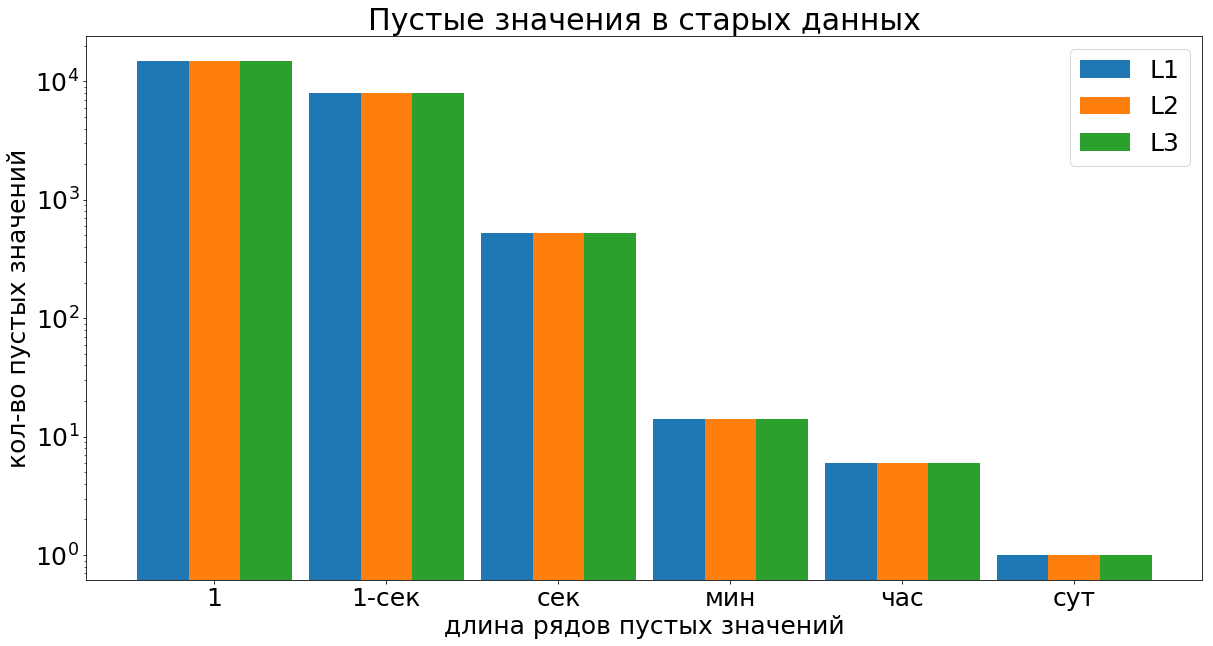

In [22]:
#y1=yL1
#y2=yL2
#y3=yL3
x=np.arange(0,len(y))
fig1, ax1 =plt.subplots(figsize=(20,10))
ax1.bar(x-0.3,y1, width=0.3, label='L1')
ax1.bar(x,y2, width=0.3, label='L2')
ax1.bar(x+0.3,y3, width=0.3, label='L3')
ax1.legend(loc='upper right', fontsize=25)
ax1.tick_params(axis='both', labelsize=25)
ax1.xaxis.set_ticks(np.arange(0, 6, 1.0 ))
ax1.set_xticklabels(['1','1-сек','cек','мин','чаc','сут'])
ax1.set_yscale ('log')
ax1.set_ylabel('кол-во пустых значений',fontsize=25)
ax1.set_xlabel('длина рядов пустых значений',fontsize=25)
ax1.set_title('Пустые значения в старых данных', fontsize = 30)

Text(0.5,1,'Процент пропущенных данных от общего числа измерений на нижнем уровне')

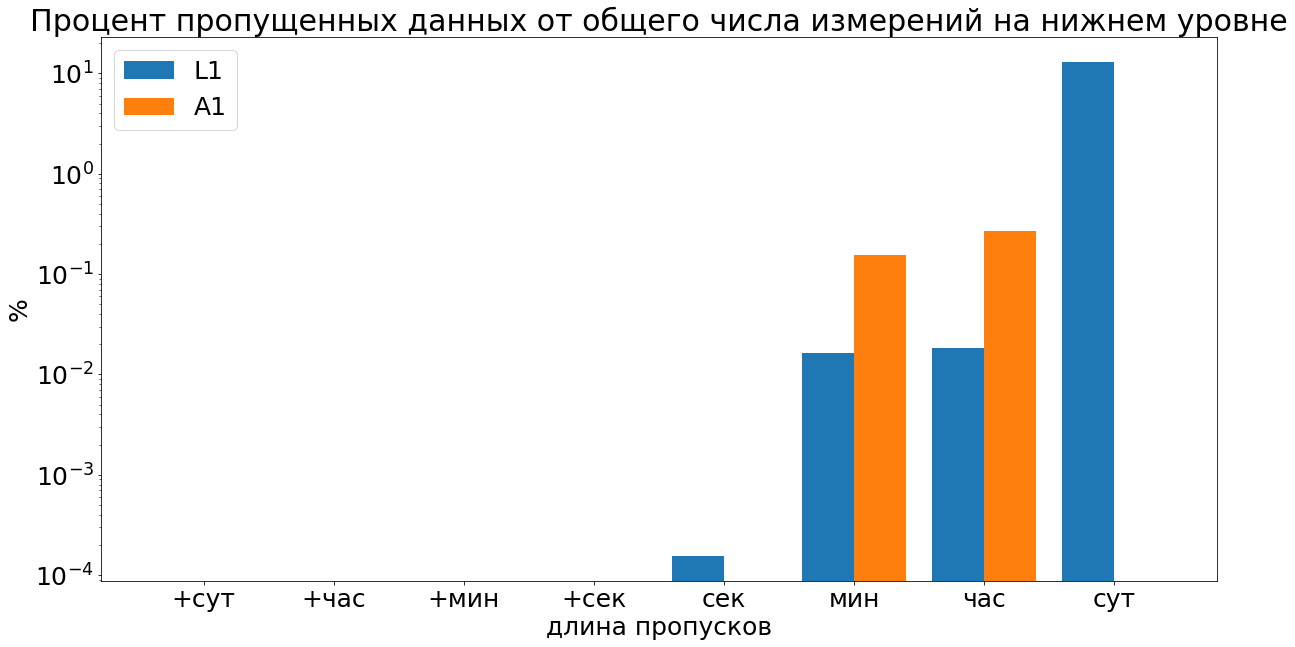

In [126]:
fig1, ax1 =plt.subplots(figsize=(20,10))

ax1.bar(x-0.2,yL1n*100/393768000, width=0.4, label='L1')
ax1.bar(x+0.2,yA1n*100/89856000, width=0.4, label='A1')
ax1.legend(loc='upper left', fontsize=25)
ax1.tick_params(axis='both', labelsize=25)
ax1.xaxis.set_ticks(np.arange(0, 8, 1.0 ))
ax1.set_xticklabels(['+сут','+час','+мин','+сек','сек','мин','чаc','сут'])
ax1.set_yscale ('log')
ax1.set_ylabel('%',fontsize=25)
ax1.set_xlabel('длина пропусков',fontsize=25)
ax1.set_title('Процент пропущенных данных от общего числа измерений на нижнем уровне', fontsize = 30)

Text(0.5,1,'Отклонение частоты в старых данных')

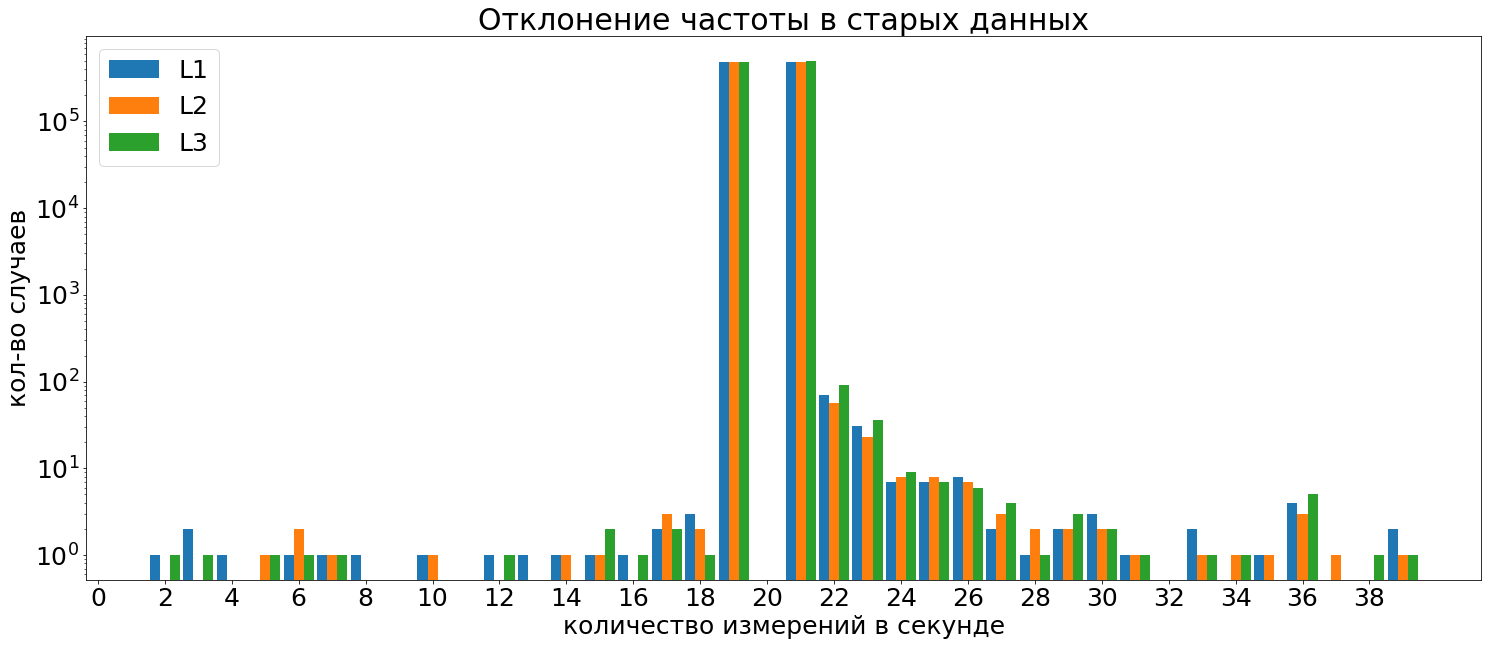

In [149]:
fig1, ax1 =plt.subplots(figsize=(25,10))
x1=20-np.array(f_l_L1)
x2=20-np.array(f_l_L2)
x3=20-np.array(f_l_L3)
y1=np.array(f_c_L1)
y2=np.array(f_c_L2)
y3=np.array(f_c_L3)
ax1.bar(x1-0.3,y1, width=0.3, label='L1')
ax1.bar(x2,y2, width=0.3, label='L2')
ax1.bar(x3+0.3,y3, width=0.3, label='L3')
ax1.legend(loc='upper left', fontsize=25)
ax1.tick_params(axis='both', labelsize=25)
ax1.xaxis.set_ticks(np.arange(0, 40, 2.0 ))
ax1.set_xticklabels(['+сут','+час','+мин','+сек','сек','мин','чаc','сут'])
ax1.set_yscale ('log')
ax1.set_ylabel('кол-во случаев',fontsize=25)
ax1.set_xlabel('количество измерений в секунде',fontsize=25)
ax1.set_title('Отклонение частоты в старых данных', fontsize = 30)

In [154]:
def y_maker_g (dt1, dt2): 
    y=np.zeros(10)
    yn=np.zeros(10)
    for i in range(len(dt1)):    
        if dt1[i]<=-1728000:
            y[0]+=dt2[i]
            yn[0]+=dt2[i]*dt1[i]
        if dt1[i]<=-72000 and dt1[i]>-1728000:
            y[1]+=dt2[i]
            yn[1]+=dt2[i]*dt1[i]
        if dt1[i]<=-1200 and dt1[i]>-72000:
            y[2]+=dt2[i]
            yn[2]+=dt2[i]*dt1[i]
        if dt1[i]<=-20 and dt1[i]>-1200:
            y[3]+=dt2[i]
            yn[3]+=dt2[i]*dt1[i]
        if dt1[i]<=-20 and dt1[i]>-1200:
            y[3]+=dt2[i]
            yn[3]+=dt2[i]*dt1[i]
        if dt1[i]<-2 and dt1[i]>-20:
            y[4]+=dt2[i]
            yn[4]+=dt2[i]*dt1[i]
        if dt1[i]>2 and dt1[i]<20:
            y[5]+=dt2[i]
            yn[5]+=dt2[i]*dt1[i]
        if dt1[i]>=20 and dt1[i]<1200:
            y[6]+=dt2[i]
            yn[6]+=dt2[i]*dt1[i]
        if dt1[i]>=1200 and dt1[i]<72000:
            y[7]+=dt2[i]
            yn[7]+=dt2[i]*dt1[i]
        if dt1[i]>=72000 and dt1[i]<1728000:
            y[8]+=dt2[i]
            yn[8]+=dt2[i]*dt1[i]
        if dt1[i]>=1728000:
            y[9]+=dt2[i]
            yn[9]+=dt2[i]*dt1[i]
    return y, yn

## Подсчет пропусков в новых данных

In [158]:
output_directory='C:\\TOWER_DATA\\data_ncdf\\A1_out'
input_directory='C:\\TOWER_DATA\\data_ncdf\\A1\\'

all_time=[]
files=os.listdir(input_directory)
for file_name in files:
    data = nc.Dataset(input_directory+file_name,'r')
    time=data.variables['time']
    all_time=np.concatenate(all_time,time[:])
    
time_start=int(all_time[0])
time2=time_start
gap=[]
time_gap=[]
gap_full=[]
time_gap_full=[]
gap2=0
time_gap2=time2
delta_time2=0
j=-1

f_out_full=open(output_directory+'\\full_gaps.csv','w')
f_out_full.write('time'+'\t'+'gap'+'\n')
f_out=open(output_directory+'\\gaps.csv','w')
f_out.write('time'+'\t'+'gap'+'\n')

for i in all_time:     
    j+=1
    time1=time2
    time2=int(i)
    if time2!=time1: 
        delta_time=time2-time1
        if delta_time!=1 or j!=20: #критерий пропуска
            gap_full.append((delta_time-1)*20+20-j) #записываем величину пропуска
            time_gap_full.append(datetime.fromtimestamp(time1)) #записываем время пропуска
            f_out_full.write(str(gap_full[-1])+', '+str((time_gap_full[-1]))+'\n')
            gap1=gap2
            gap2=(delta_time-1)*20+20-j
            time_gap1=time_gap2
            time_gap2=time1
            delta_time1=delta_time2
            delta_time2=delta_time
            #Если после текущего пропуска сразу идет следующий пропуск с противоположным знаком и равный по модулю, он не учитывается
            if gap1!=0 and (time_gap2-time_gap1!=delta_time1 or gap1!=-(gap2)): 
                #Если после текущего пропуска сразу идет следующий пропуск с противоположным знаком
                if (time_gap2-time_gap1==delta_time1 and gap1>0 and gap2<0) or (
                    time_gap2-time_gap1==delta_time1 and gap1<0 and gap2>0):
                    gap2=gap1+gap2
                #Если после текущего пропуска не сразу идет следующий пропуск или сразу, но с тем же знаком
                else:
                    gap.append(gap1)
                    time_gap.append(datetime.fromtimestamp(time_gap1))
                    f_out.write(str(datetime.fromtimestamp(time_gap1))+', '+str(gap1)+'\n')
        j=0

gap.append(gap2)
time_gap.append(datetime.fromtimestamp(time_gap2))
f_out_full.write(str(datetime.fromtimestamp(time_gap2))+', '+str(gap2)+'\n')
f_out.write(str(datetime.fromtimestamp(time_gap2))+', '+str(gap2)+'\n')
f_out.close()
f_out_full.close()

f_out_total=open(output_directory+'\\total_gaps.csv','w')
f_out_total.write('length_gap'+','+'counts_gap'+'\n')
length,counts=np.unique(gap, return_counts=True)
for i in range(len(length)):
    f_out_total.write(str(length[i])+','+str(counts[i])+'\n')
f_out_total.close()    
print(length, counts)



output_directory='C:\\TOWER_DATA\\data_ncdf\\A2_out'
input_directory='C:\\TOWER_DATA\\data_ncdf\\A2\\'

all_time=[]
files=os.listdir(input_directory)
for file_name in files:
    data = nc.Dataset(input_directory+file_name,'r')
    time=data.variables['time']
    all_time=np.concatenate((all_time,time[:]))
    
time_start=int(all_time[0])
time2=time_start
gap=[]
time_gap=[]
gap_full=[]
time_gap_full=[]
gap2=0
time_gap2=time2
delta_time2=0
j=-1

f_out_full=open(output_directory+'\\full_gaps.csv','w')
f_out_full.write('time'+'\t'+'gap'+'\n')
f_out=open(output_directory+'\\gaps.csv','w')
f_out.write('time'+'\t'+'gap'+'\n')

for i in all_time:     
    j+=1
    time1=time2
    time2=int(i)
    if time2!=time1: 
        delta_time=time2-time1
        if delta_time!=1 or j!=20: #критерий пропуска
            gap_full.append((delta_time-1)*20+20-j) #записываем величину пропуска
            time_gap_full.append(datetime.fromtimestamp(time1)) #записываем время пропуска
            f_out_full.write(str(gap_full[-1])+', '+str((time_gap_full[-1]))+'\n')
            gap1=gap2
            gap2=(delta_time-1)*20+20-j
            time_gap1=time_gap2
            time_gap2=time1
            delta_time1=delta_time2
            delta_time2=delta_time
            #Если после текущего пропуска сразу идет следующий пропуск с противоположным знаком и равный по модулю, он не учитывается
            if gap1!=0 and (time_gap2-time_gap1!=delta_time1 or gap1!=-(gap2)): 
                #Если после текущего пропуска сразу идет следующий пропуск с противоположным знаком
                if (time_gap2-time_gap1==delta_time1 and gap1>0 and gap2<0) or (
                    time_gap2-time_gap1==delta_time1 and gap1<0 and gap2>0):
                    gap2=gap1+gap2
                #Если после текущего пропуска не сразу идет следующий пропуск или сразу, но с тем же знаком
                else:
                    gap.append(gap1)
                    time_gap.append(datetime.fromtimestamp(time_gap1))
                    f_out.write(str(datetime.fromtimestamp(time_gap1))+', '+str(gap1)+'\n')
        j=0

gap.append(gap2)
time_gap.append(datetime.fromtimestamp(time_gap2))
f_out_full.write(str(datetime.fromtimestamp(time_gap2))+', '+str(gap2)+'\n')
f_out.write(str(datetime.fromtimestamp(time_gap2))+', '+str(gap2)+'\n')
f_out.close()
f_out_full.close()

f_out_total=open(output_directory+'\\total_gaps.csv','w')
f_out_total.write('length_gap'+','+'counts_gap'+'\n')
length,counts=np.unique(gap, return_counts=True)
for i in range(len(length)):
    f_out_total.write(str(length[i])+','+str(counts[i])+'\n')
f_out_total.close()    
print(length, counts)



output_directory='C:\\TOWER_DATA\\data_ncdf\\A3_out'
input_directory='C:\\TOWER_DATA\\data_ncdf\\A3\\'

all_time=[]
files=os.listdir(input_directory)
for file_name in files:
    data = nc.Dataset(input_directory+file_name,'r')
    time=data.variables['time']
    all_time=np.concatenate((all_time,time[:]))
    
time_start=int(all_time[0])
time2=time_start
gap=[]
time_gap=[]
gap_full=[]
time_gap_full=[]
gap2=0
time_gap2=time2
delta_time2=0
j=-1

f_out_full=open(output_directory+'\\full_gaps.csv','w')
f_out_full.write('time'+'\t'+'gap'+'\n')
f_out=open(output_directory+'\\gaps.csv','w')
f_out.write('time'+'\t'+'gap'+'\n')

for i in all_time:     
    j+=1
    time1=time2
    time2=int(i)
    if time2!=time1: 
        delta_time=time2-time1
        if delta_time!=1 or j!=20: #критерий пропуска
            gap_full.append((delta_time-1)*20+20-j) #записываем величину пропуска
            time_gap_full.append(datetime.fromtimestamp(time1)) #записываем время пропуска
            f_out_full.write(str(gap_full[-1])+', '+str((time_gap_full[-1]))+'\n')
            gap1=gap2
            gap2=(delta_time-1)*20+20-j
            time_gap1=time_gap2
            time_gap2=time1
            delta_time1=delta_time2
            delta_time2=delta_time
            #Если после текущего пропуска сразу идет следующий пропуск с противоположным знаком и равный по модулю, он не учитывается
            if gap1!=0 and (time_gap2-time_gap1!=delta_time1 or gap1!=-(gap2)): 
                #Если после текущего пропуска сразу идет следующий пропуск с противоположным знаком
                if (time_gap2-time_gap1==delta_time1 and gap1>0 and gap2<0) or (
                    time_gap2-time_gap1==delta_time1 and gap1<0 and gap2>0):
                    gap2=gap1+gap2
                #Если после текущего пропуска не сразу идет следующий пропуск или сразу, но с тем же знаком
                else:
                    gap.append(gap1)
                    time_gap.append(datetime.fromtimestamp(time_gap1))
                    f_out.write(str(datetime.fromtimestamp(time_gap1))+', '+str(gap1)+'\n')
        j=0

gap.append(gap2)
time_gap.append(datetime.fromtimestamp(time_gap2))
f_out_full.write(str(datetime.fromtimestamp(time_gap2))+', '+str(gap2)+'\n')
f_out.write(str(datetime.fromtimestamp(time_gap2))+', '+str(gap2)+'\n')
f_out.close()
f_out_full.close()

f_out_total=open(output_directory+'\\total_gaps.csv','w')
f_out_total.write('length_gap'+','+'counts_gap'+'\n')
length,counts=np.unique(gap, return_counts=True)
for i in range(len(length)):
    f_out_total.write(str(length[i])+','+str(counts[i])+'\n')
f_out_total.close()    
print(length, counts)

[-288001  -24001     -15     -13      -6      -5      -4      -3      -2
      -1       1       2       3       4       5       6       7       8
       9      10      11      12      14      15      18    2646    2854
    4787    7221    9955   11936   11985   11986   11993   11994   23985
   29253  239986] [   1    1    1    1    4   77   83   99  113  902 2171  183  166  158
  125   60   32   12    9    2    4    3    1    4    1    1    1    1
    1    1    1    1    1    1    1    1    1    1]
[-203998  -36000  -24000  -23999     -28     -24     -22     -20     -18
     -16     -15     -12     -10      -9      -6      -5      -4      -3
      -2      -1       1       2       3       4       5       6       7
       8       9      10      12      13      14      18      19     158
    2642    2856    4788    7221   11591   11936   11980   11981   11986
   11988   12000   23981   23988   29253   35986  155987] [   1    2    1    1    1    2   22 5350   21    2    1    2    1    1
  

In [2]:
test=pd.read_csv('C:\\TOWER_DATA\\DATA_GAPS\\frank\\full_gaps.csv', delimiter=', ', comment='#')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [3]:
for i in range(len(test['time'])):
    if test['gap'][i]>20 or test['gap'][i]<-20: 
        print(i,test['gap'][i],test['time'][i])

1 367.0 2019-10-27 13:20:59
2 -367.0 2019-10-27 13:21:18
30887 10520999.0 2019-11-03 13:56:00
30895 211.0 2019-11-09 16:04:01
30898 21.0 2019-11-09 16:04:31
30899 33.0 2019-11-09 16:04:33
30901 102.0 2019-11-09 16:04:37
69643 22.0 2019-11-17 10:32:32
69644 -22.0 2019-11-17 10:32:34
69692 83.0 2019-11-17 10:44:31
69693 -84.0 2019-11-17 10:44:36
69701 39.0 2019-11-17 10:45:12
69702 26.0 2019-11-17 10:45:15
69704 -53.0 2019-11-17 10:45:19
69716 46050.0 2019-11-17 10:46:16
69720 173.0 2019-11-17 11:25:35
69721 -173.0 2019-11-17 11:25:44
69722 1193.0 2019-11-17 11:25:56
69723 -1192.0 2019-11-17 11:26:56
69912 137.0 2019-11-17 11:43:13
69913 -138.0 2019-11-17 11:43:20
69919 359.0 2019-11-17 11:43:55
69920 -359.0 2019-11-17 11:44:13
69931 1182.0 2019-11-17 11:45:29
69932 -1193.0 2019-11-17 11:46:29
69935 80.0 2019-11-17 12:12:21
69936 -80.0 2019-11-17 12:12:26
69937 368.0 2019-11-17 12:12:27
69938 -368.0 2019-11-17 12:12:46
123462 33.0 2019-11-28 10:59:02
123463 -33.0 2019-11-28 10:59:04
1234

In [43]:
test

time     gap
0        2019-10-27 13:00:00 -5400.0
1        2019-10-27 12:55:30    14.0
2        2019-10-27 12:58:31    -1.0
3        2019-10-27 12:58:32     1.0
4        2019-10-27 12:58:41    -1.0
5        2019-10-27 12:58:42     1.0
6        2019-10-27 12:58:51    -1.0
7        2019-10-27 12:58:52     1.0
8        2019-10-27 12:59:01    -1.0
9        2019-10-27 12:59:02     1.0
10       2019-10-27 12:59:10    -1.0
11       2019-10-27 12:59:12     1.0
12       2019-10-27 12:59:20    -1.0
13       2019-10-27 12:59:22     1.0
14       2019-10-27 12:59:30    -1.0
15       2019-10-27 12:59:32     1.0
16       2019-10-27 12:59:40    -1.0
17       2019-10-27 12:59:41     1.0
18       2019-10-27 12:59:50    -1.0
19       2019-10-27 12:59:52     1.0
20       2019-10-27 12:59:59    -1.0
21       2019-10-27 13:00:01     1.0
22       2019-10-27 13:00:09    -1.0
23       2019-10-27 13:00:11     1.0
24       2019-10-27 13:00:19    -1.0
25       2019-10-27 13:00:22     1.0
26       2019-10-27 13:00:29    -1.0
27       2019-10-27 13:00:31     1.0
28       2019-10-27 13:00:38    -1.0
29       2019-10-27 13:00:41     1.0
...                      ...     ...
1091030  2020-06-11 10:16:00    -1.0
1091031  2020-06-11 10:16:07     1.0
1091032  2020-06-11 10:16:10    -1.0
1091033  2020-06-11 10:16:17     1.0
1091034  2020-06-11 10:16:19    -1.0
1091035  2020-06-11 10:16:27     1.0
1091036  2020-06-11 10:16:29    -1.0
1091037  2020-06-11 10:16:37     1.0
1091038  2020-06-11 10:16:39    -1.0
1091039  2020-06-11 10:16:47     1.0
1091040  2020-06-11 10:16:49    -1.0
1091041  2020-06-11 10:16:57     1.0
1091042  2020-06-11 10:16:58    -1.0
1091043  2020-06-11 10:17:07     1.0
1091044  2020-06-11 10:17:08    -1.0
1091045  2020-06-11 10:17:16     1.0
1091046  2020-06-11 10:17:18    -1.0
1091047  2020-06-11 10:17:26     1.0
1091048  2020-06-11 10:17:28    -1.0
1091049  2020-06-11 10:17:36     1.0
1091050  2020-06-11 10:17:37    -1.0
1091051  2020-06-11 10:17:46     1.0
1091052  2020-06-11 10:17:47    -1.0
1091053  2020-06-11 10:17:56     1.0
1091054  2020-06-11 10:17:57    -1.0
1091055  2020-06-11 10:18:06     1.0
1091056  2020-06-11 10:18:07    -1.0
1091057  2020-06-11 10:18:45     1.0
1091058  2020-06-11 10:18:46    -1.0
1091059  2020-06-11 10:18:46    -1.0

[1091060 rows x 2 columns]

In [21]:
gap_L3= pd.read_csv(r'C:\TOWER_DATA\DATA_GAPS\io\gaps.csv', delimiter=', ', comment='#')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [69]:
i, = np.where(gap_L3['gap'].values == max(gap_L3['gap']))
gap_L3['time'][int(i)]

'2019-10-02 06:01:01'

In [ ]:
gap_L1= pd.read_csv(r'C:\TOWER_DATA\DATA_GAPS\frank\gaps.csv', delimiter=', ', comment='#')
gap_L2= pd.read_csv(r'C:\TOWER_DATA\DATA_GAPS\ifa\gaps.csv', delimiter=', ', comment='#')
gap_L3= pd.read_csv(r'C:\TOWER_DATA\DATA_GAPS\io\gaps.csv', delimiter=', ', comment='#')
empty_L1=pd.read_csv(r'C:\TOWER_DATA\DATA_GAPS\frank\empty.csv', delimiter=', ', comment='#')
empty_L2=pd.read_csv(r'C:\TOWER_DATA\DATA_GAPS\ifa\empty.csv', delimiter=', ', comment='#')
empty_L3=pd.read_csv(r'C:\TOWER_DATA\DATA_GAPS\io\empty.csv', delimiter=', ', comment='#')


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
